O piloto mais rápido em média é Jack Aitken com um tempo médio de 63.319 segundos.


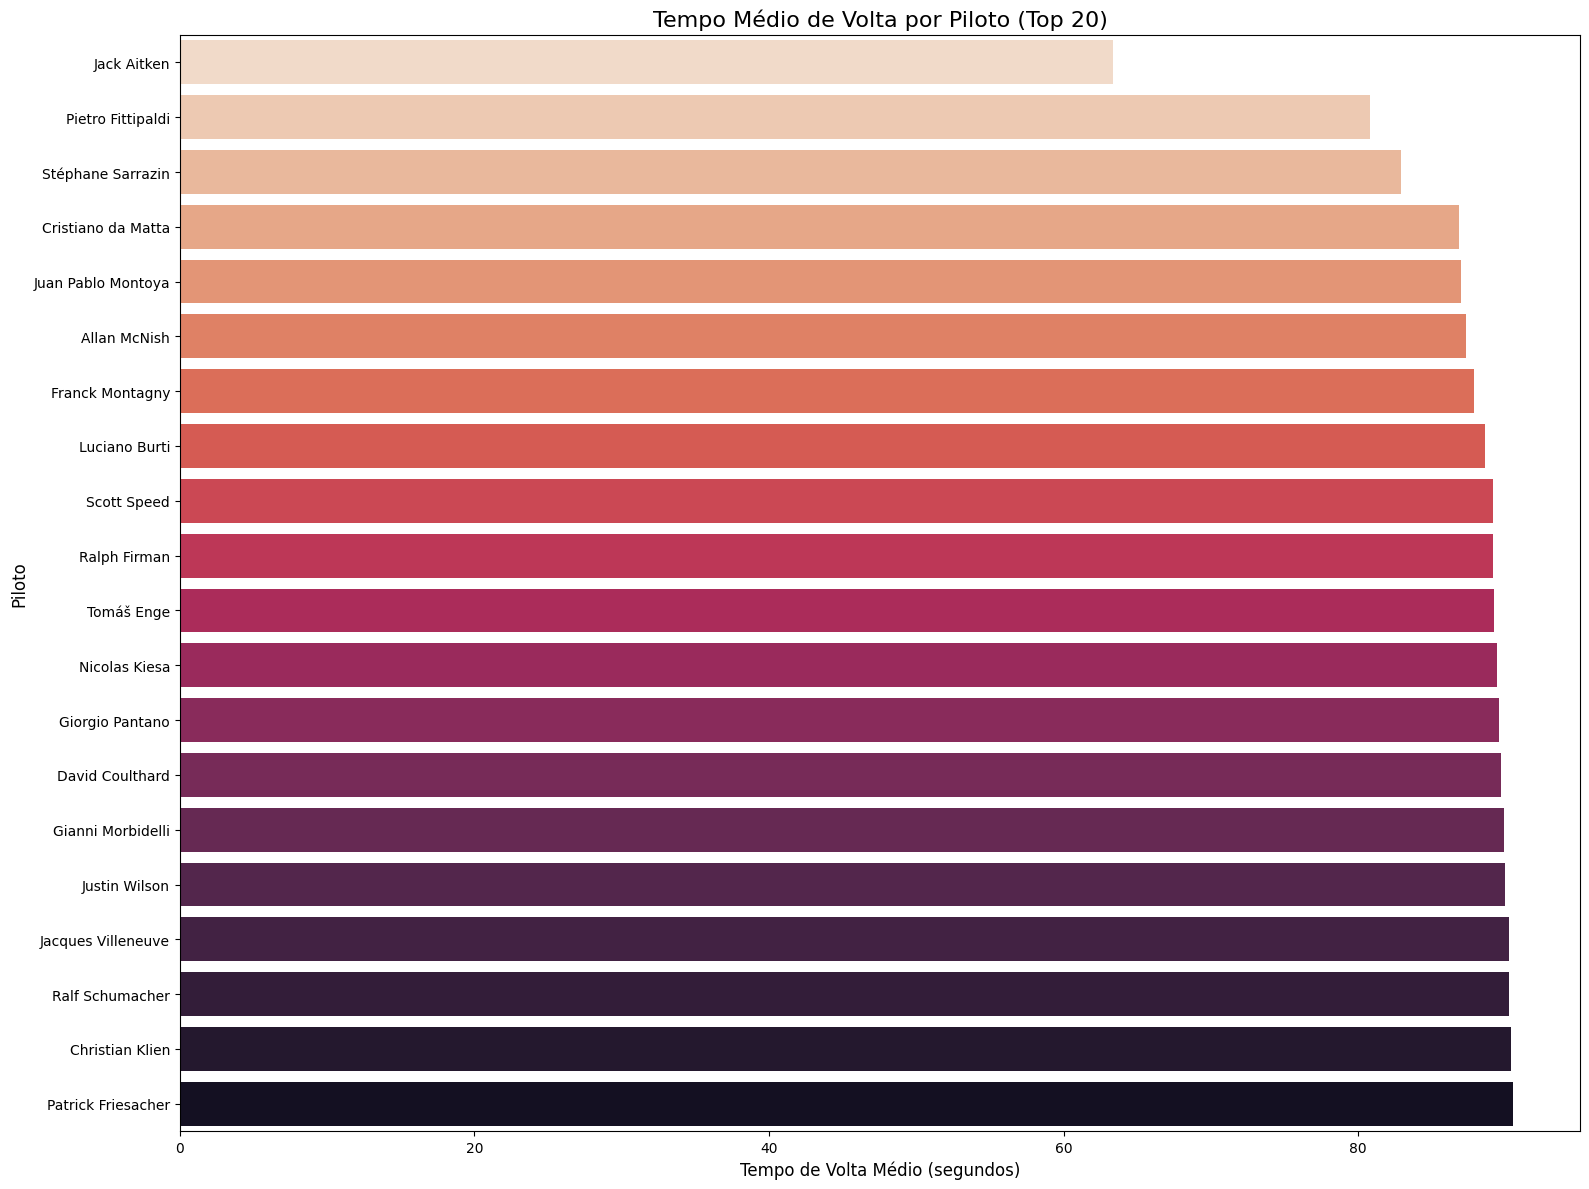

In [ ]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Garanta que o PySpark esteja instalado em seu ambiente:
# pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, concat_ws

# Configuração do Spark Session
os.environ['HADOOP_HOME'] = 'C:\\hadoop'
sys.path.append('C:\\hadoop\\bin')

spark = SparkSession.builder \
    .appName("AnaliseETL-DataViz") \
    .master("local[*]") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()

# Carregamento dos dados
base_path = "C:/Users/julii/OneDrive/Documentos/formula1-analytics/Data Layer/raw/dados_originais"
file_names = [
    "circuits", "constructors", "drivers", "lap_times", "pit_stops",
    "qualifying", "races", "results", "status", "sprint_results"
]
dataframes = {}
try:
    for name in file_names:
        file_path = f"{base_path}/{name}.csv"
        dataframes[name] = spark.read.csv(file_path, header=True, inferSchema=True, nullValue="\\N")
except Exception as e:
    print(f"\nERRO AO CARREGAR OS ARQUIVOS. Verifique o caminho base.")
    spark.stop()
    exit()

# 1. Calcular o tempo médio de volta por piloto
avg_lap_time_df = dataframes['lap_times'].groupBy("driverId") \
    .agg(avg("milliseconds").alias("avg_milliseconds"))

# 2. Juntar com o DataFrame de pilotos para obter os nomes
drivers_with_label = dataframes['drivers'].withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))

# Juntando os dataframes e convertendo para segundos
avg_lap_time_with_driver = avg_lap_time_df.join(drivers_with_label, "driverId") \
    .withColumn("avg_seconds", col("avg_milliseconds") / 1000) \
    .orderBy("avg_seconds")

# 3. Converter para Pandas para plotagem
plot_data_2 = avg_lap_time_with_driver.select("driver_name", "avg_seconds").toPandas()

# 4. Criar o gráfico de colunas horizontais com os 20 pilotos mais rápidos
plt.figure(figsize=(16, 12))
sns.barplot(
    x="avg_seconds",
    y="driver_name",
    data=plot_data_2.head(20),
    orient='h',
    palette="rocket_r",
    hue="driver_name",
    legend=False
)

plt.title('Tempo Médio de Volta por Piloto (Top 20)', fontsize=16)
plt.xlabel('Tempo de Volta Médio (segundos)', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()

# Salvar o gráfico em um arquivo

# Exibindo o insight
fastest_driver = plot_data_2.iloc[0]
print(f"O piloto mais rápido em média é {fastest_driver['driver_name']} com um tempo médio de {fastest_driver['avg_seconds']:.3f} segundos.")

plt.show()

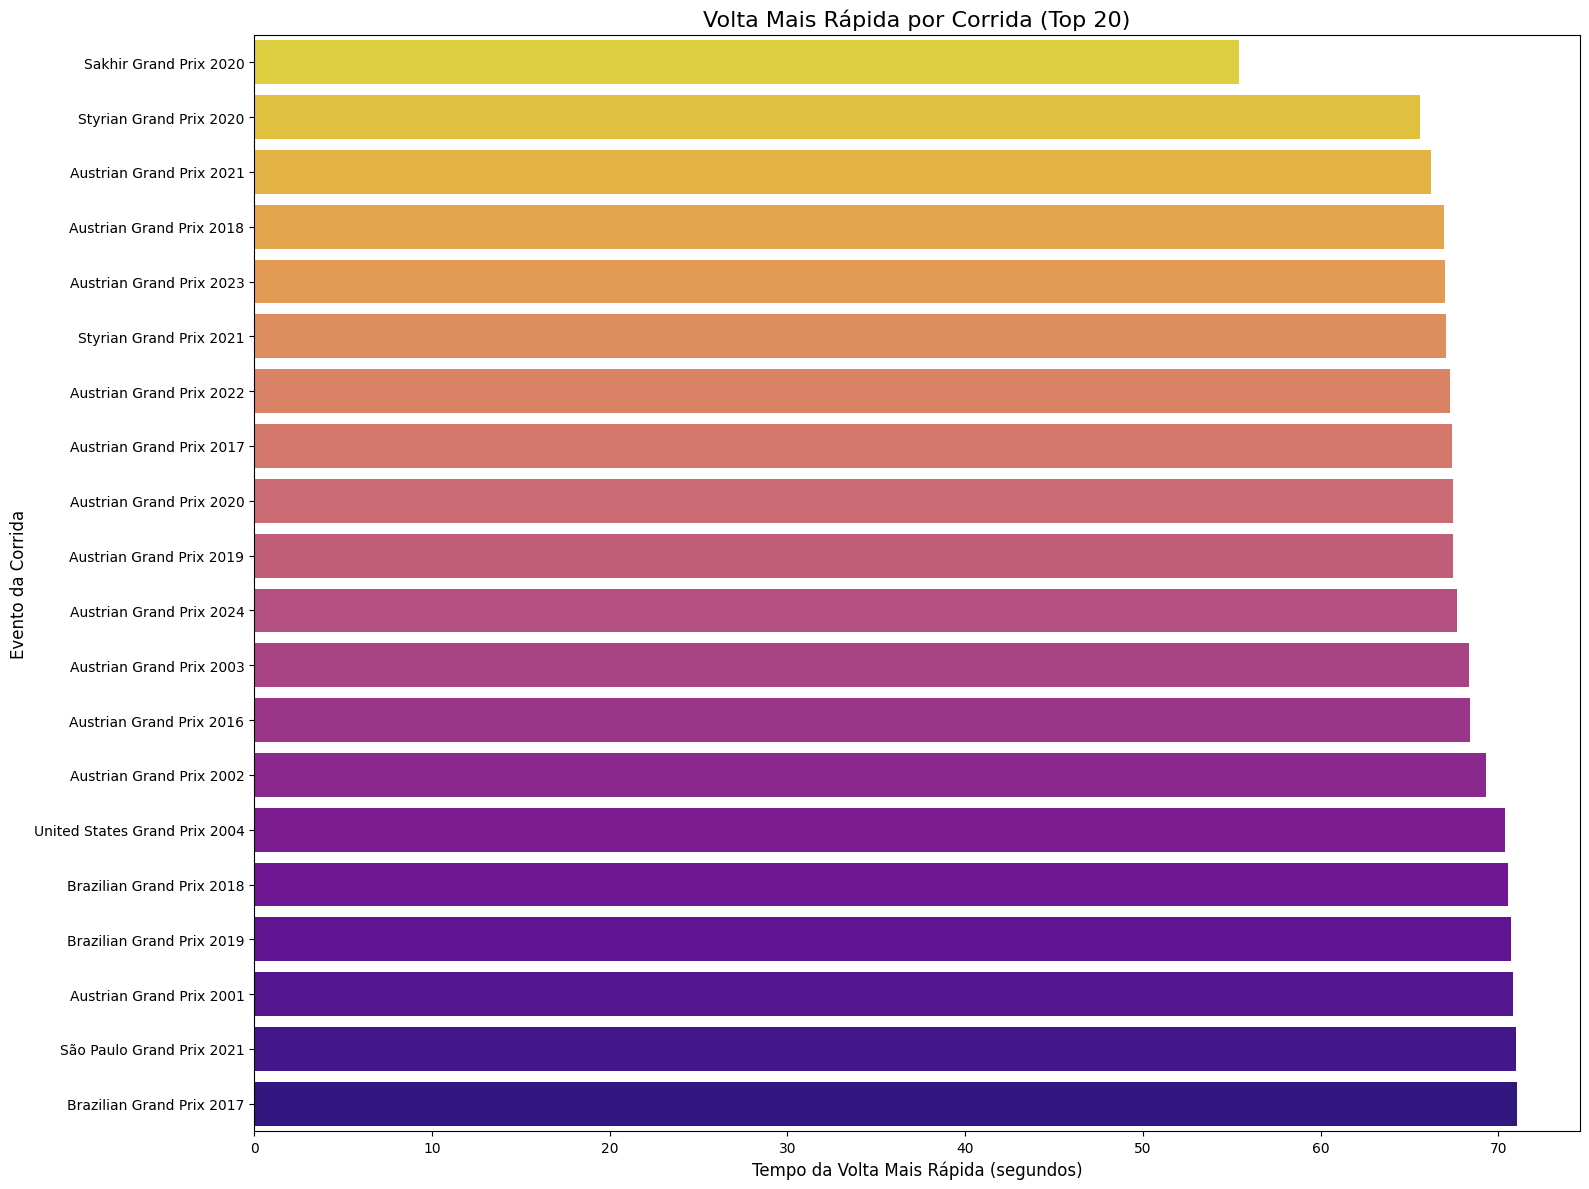

A corrida com a volta mais rápida foi a 'Sakhir Grand Prix 2020' com um tempo de 55.404 segundos.


In [ ]:
# Importe a função 'min' junto com as outras
from pyspark.sql.functions import min, col, concat_ws

# 1. Encontrar o tempo mínimo (volta mais rápida) para cada raceId
# O resto do código permanece o mesmo
fastest_lap_per_race_df = dataframes['lap_times'].groupBy("raceId") \
    .agg(min("milliseconds").alias("fastest_lap_ms"))

# 2. Juntar com o DataFrame de corridas para obter os nomes e anos
races_with_label = dataframes['races'].withColumn("race_event_label", concat_ws(" ", col("name"), col("year")))

# Juntando os dataframes, convertendo para segundos e ordenando
fastest_lap_details_df = fastest_lap_per_race_df.join(races_with_label, "raceId") \
    .withColumn("fastest_lap_s", col("fastest_lap_ms") / 1000) \
    .orderBy("fastest_lap_s")

# 3. Converter para Pandas para plotagem
plot_data_3 = fastest_lap_details_df.select("race_event_label", "fastest_lap_s").toPandas()

# 4. Criar o gráfico de colunas horizontais com as 20 corridas mais rápidas
plt.figure(figsize=(16, 12))
sns.barplot(
    x="fastest_lap_s",
    y="race_event_label",
    data=plot_data_3.head(20),
    orient='h',
    palette="plasma_r",
    hue="race_event_label",
    legend=False
)

plt.title('Volta Mais Rápida por Corrida (Top 20)', fontsize=16)
plt.xlabel('Tempo da Volta Mais Rápida (segundos)', fontsize=12)
plt.ylabel('Evento da Corrida', fontsize=12)
plt.tight_layout()

# Salvar e mostrar o gráfico
plt.show()

# Exibindo o insight
fastest_race = plot_data_3.iloc[0]
print(f"A corrida com a volta mais rápida foi a '{fastest_race['race_event_label']}' com um tempo de {fastest_race['fastest_lap_s']:.3f} segundos.")

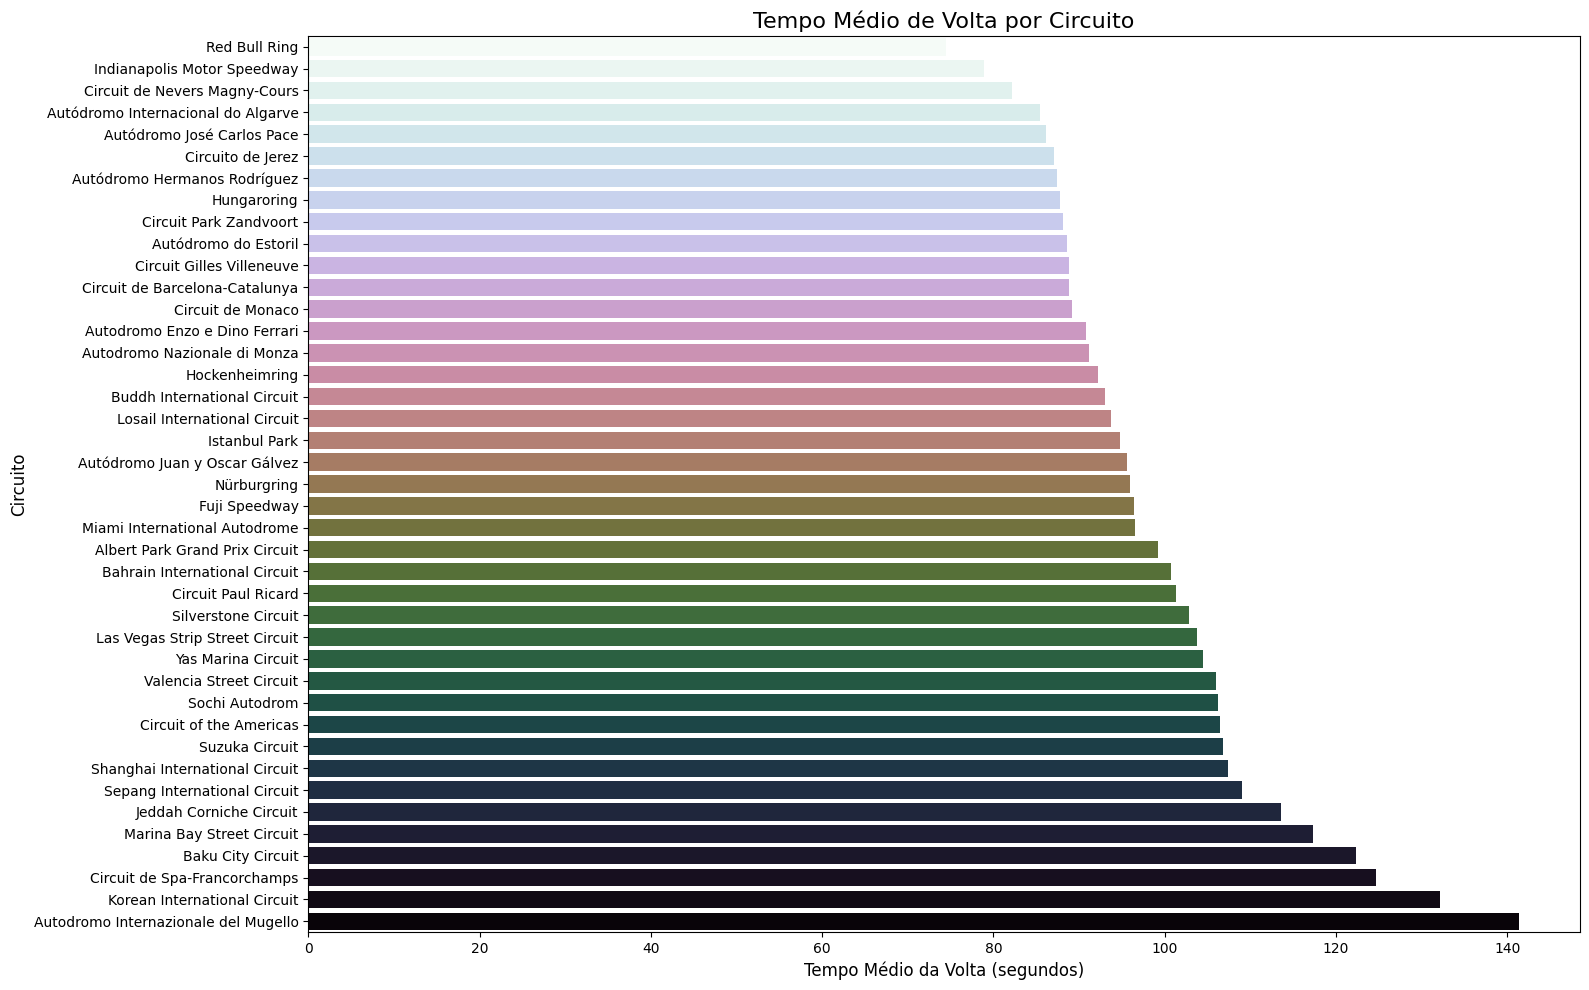

A pista mais rápida em média é: 'Red Bull Ring' com um tempo de 74.421 segundos.
A pista mais lenta em média é: 'Autodromo Internazionale del Mugello' com um tempo de 141.405 segundos.


In [ ]:
from pyspark.sql.functions import avg, col

# 1. Calcular o tempo médio de volta para cada corrida (raceId)
avg_time_per_race = dataframes['lap_times'].groupBy("raceId") \
    .agg(avg("milliseconds").alias("avg_lap_ms_race"))

# 2. Juntar com a tabela 'races' para obter o circuitId de cada corrida
race_circuit_join = avg_time_per_race.join(dataframes['races'], "raceId")

# 3. Calcular o tempo médio geral para cada circuito (circuitId)
#    Agrupamos por circuito e tiramos a média dos tempos médios de todas as corridas naquele circuito
avg_time_per_circuit = race_circuit_join.groupBy("circuitId") \
    .agg(avg("avg_lap_ms_race").alias("avg_circuit_ms"))

# 4. Juntar com a tabela 'circuits' para obter os nomes das pistas
circuit_details = avg_time_per_circuit.join(dataframes['circuits'], "circuitId") \
    .withColumn("avg_circuit_s", col("avg_circuit_ms") / 1000) \
    .orderBy("avg_circuit_s")

# 5. Converter para Pandas para plotagem
plot_data_4 = circuit_details.select("name", "avg_circuit_s").toPandas()

# 6. Criar o gráfico de colunas (barras verticais)
plt.figure(figsize=(16, 10))
sns.barplot(
    x="avg_circuit_s",
    y="name",
    data=plot_data_4,
    orient='h',
    palette="cubehelix_r",
    hue="name",
    legend=False
)

plt.title('Tempo Médio de Volta por Circuito', fontsize=16)
plt.xlabel('Tempo Médio da Volta (segundos)', fontsize=12)
plt.ylabel('Circuito', fontsize=12)
plt.tight_layout()

# Salvar o gráfico e exibi-lo
plt.show()

# 7. Apresentar o insight
fastest_circuit = plot_data_4.iloc[0]
slowest_circuit = plot_data_4.iloc[-1]

print(f"A pista mais rápida em média é: '{fastest_circuit['name']}' com um tempo de {fastest_circuit['avg_circuit_s']:.3f} segundos.")
print(f"A pista mais lenta em média é: '{slowest_circuit['name']}' com um tempo de {slowest_circuit['avg_circuit_s']:.3f} segundos.")

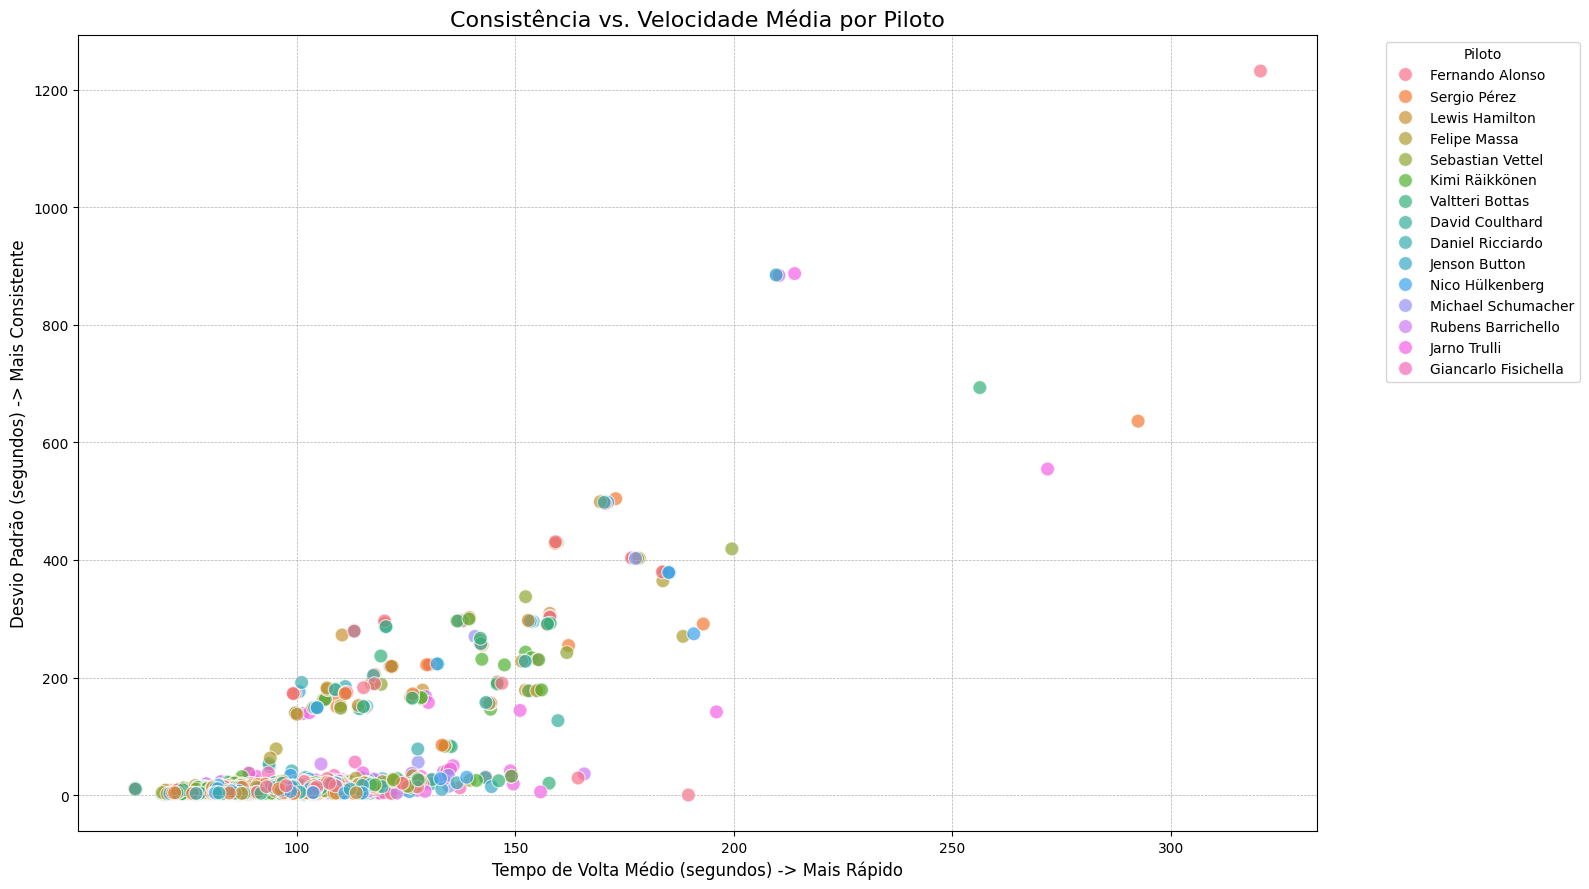

O piloto com o ritmo mais consistente (menor desvio padrão médio) é: Stéphane Sarrazin com um desvio padrão médio de 2.631 segundos.


In [ ]:
from pyspark.sql.functions import stddev, avg, col, concat_ws, count

# 1. Calcular o desvio padrão e a média de tempo de volta para cada piloto em cada corrida
driver_consistency_df = dataframes['lap_times'] \
    .groupBy("raceId", "driverId") \
    .agg(
        stddev("milliseconds").alias("stddev_ms"),
        avg("milliseconds").alias("avg_ms")
    ) \
    .filter(col("stddev_ms").isNotNull()) # Remove casos onde o desvio padrão não pode ser calculado (ex: 1 volta)

# 2. Juntar com os nomes dos pilotos
drivers_with_label = dataframes['drivers'].withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))

full_consistency_df = driver_consistency_df.join(drivers_with_label, "driverId")

# 3. Preparar dados para o gráfico
# Para manter o gráfico legível, vamos focar nos 15 pilotos com mais corridas na base de dados
top_drivers = full_consistency_df.groupBy("driver_name").count().orderBy(col("count").desc()).limit(15).toPandas()['driver_name'].tolist()

plot_data_5 = full_consistency_df \
    .withColumn("avg_s", col("avg_ms") / 1000) \
    .withColumn("stddev_s", col("stddev_ms") / 1000) \
    .select("driver_name", "avg_s", "stddev_s") \
    .toPandas()

# Filtrar o DataFrame do Pandas para incluir apenas os pilotos mais frequentes
plot_data_5_filtered = plot_data_5[plot_data_5['driver_name'].isin(top_drivers)]


# 4. Criar o gráfico de dispersão
plt.figure(figsize=(16, 9))
sns.scatterplot(
    data=plot_data_5_filtered,
    x="avg_s",
    y="stddev_s",
    hue="driver_name",
    alpha=0.7,
    s=100 # Aumenta o tamanho dos pontos
)

plt.title('Consistência vs. Velocidade Média por Piloto', fontsize=16)
plt.xlabel('Tempo de Volta Médio (segundos) -> Mais Rápido', fontsize=12)
plt.ylabel('Desvio Padrão (segundos) -> Mais Consistente', fontsize=12)
plt.legend(title='Piloto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

# 5. Calcular o insight: Quem é o mais consistente em média?
overall_consistency = full_consistency_df.groupBy("driver_name") \
    .agg(avg("stddev_ms").alias("avg_stddev")) \
    .orderBy("avg_stddev") \
    .toPandas()

most_consistent_driver = overall_consistency.iloc[0]
print(f"O piloto com o ritmo mais consistente (menor desvio padrão médio) é: {most_consistent_driver['driver_name']} com um desvio padrão médio de {most_consistent_driver['avg_stddev'] / 1000:.3f} segundos.")

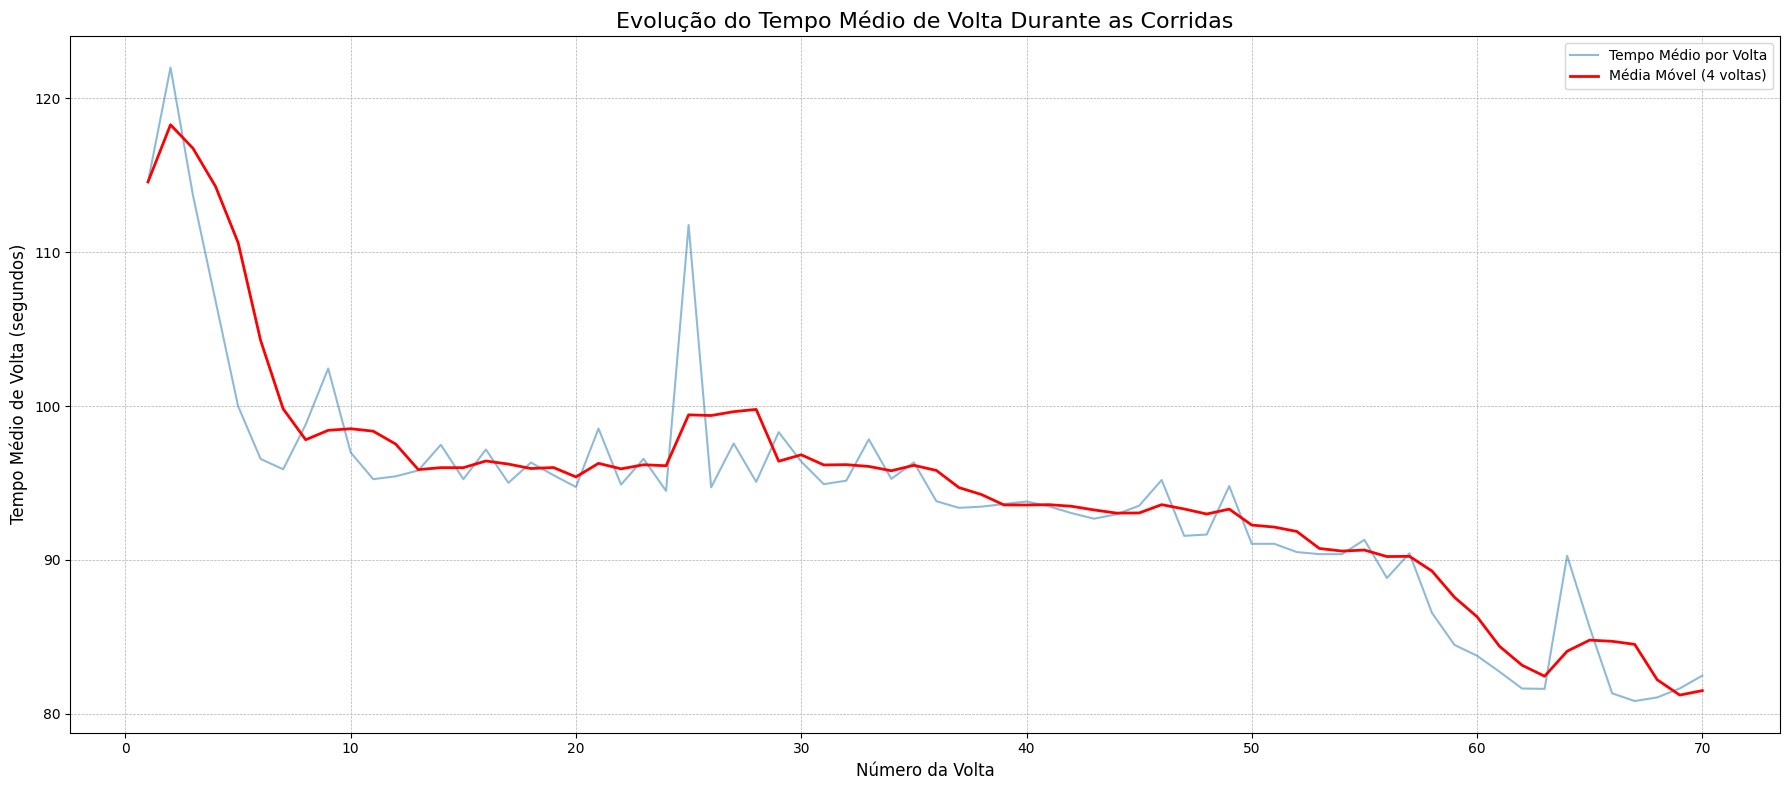

In [ ]:
from pyspark.sql.functions import avg, col

# 1. Calcular o tempo médio para cada número de volta
lap_evolution_df = dataframes['lap_times'] \
    .groupBy("lap") \
    .agg(avg("milliseconds").alias("avg_ms")) \
    .withColumn("avg_s", col("avg_ms") / 1000) \
    .orderBy("lap")

# Para manter o gráfico focado na parte principal da corrida, vamos limitar até a volta 70,
# evitando dados esparsos no final de corridas muito longas.
plot_data_6 = lap_evolution_df.filter(col("lap") <= 70).toPandas()

# 2. Calcular a média móvel (rolling average) em Pandas para suavizar a linha
plot_data_6['rolling_avg_s'] = plot_data_6['avg_s'].rolling(window=4, min_periods=1).mean()


# 3. Criar o gráfico de linha
plt.figure(figsize=(18, 8))
sns.lineplot(
    data=plot_data_6,
    x="lap",
    y="avg_s",
    label="Tempo Médio por Volta",
    alpha=0.5
)
sns.lineplot(
    data=plot_data_6,
    x="lap",
    y="rolling_avg_s",
    label="Média Móvel (4 voltas)",
    color='red',
    linewidth=2
)

plt.title('Evolução do Tempo Médio de Volta Durante as Corridas', fontsize=16)
plt.xlabel('Número da Volta', fontsize=12)
plt.ylabel('Tempo Médio de Volta (segundos)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

plt.show()

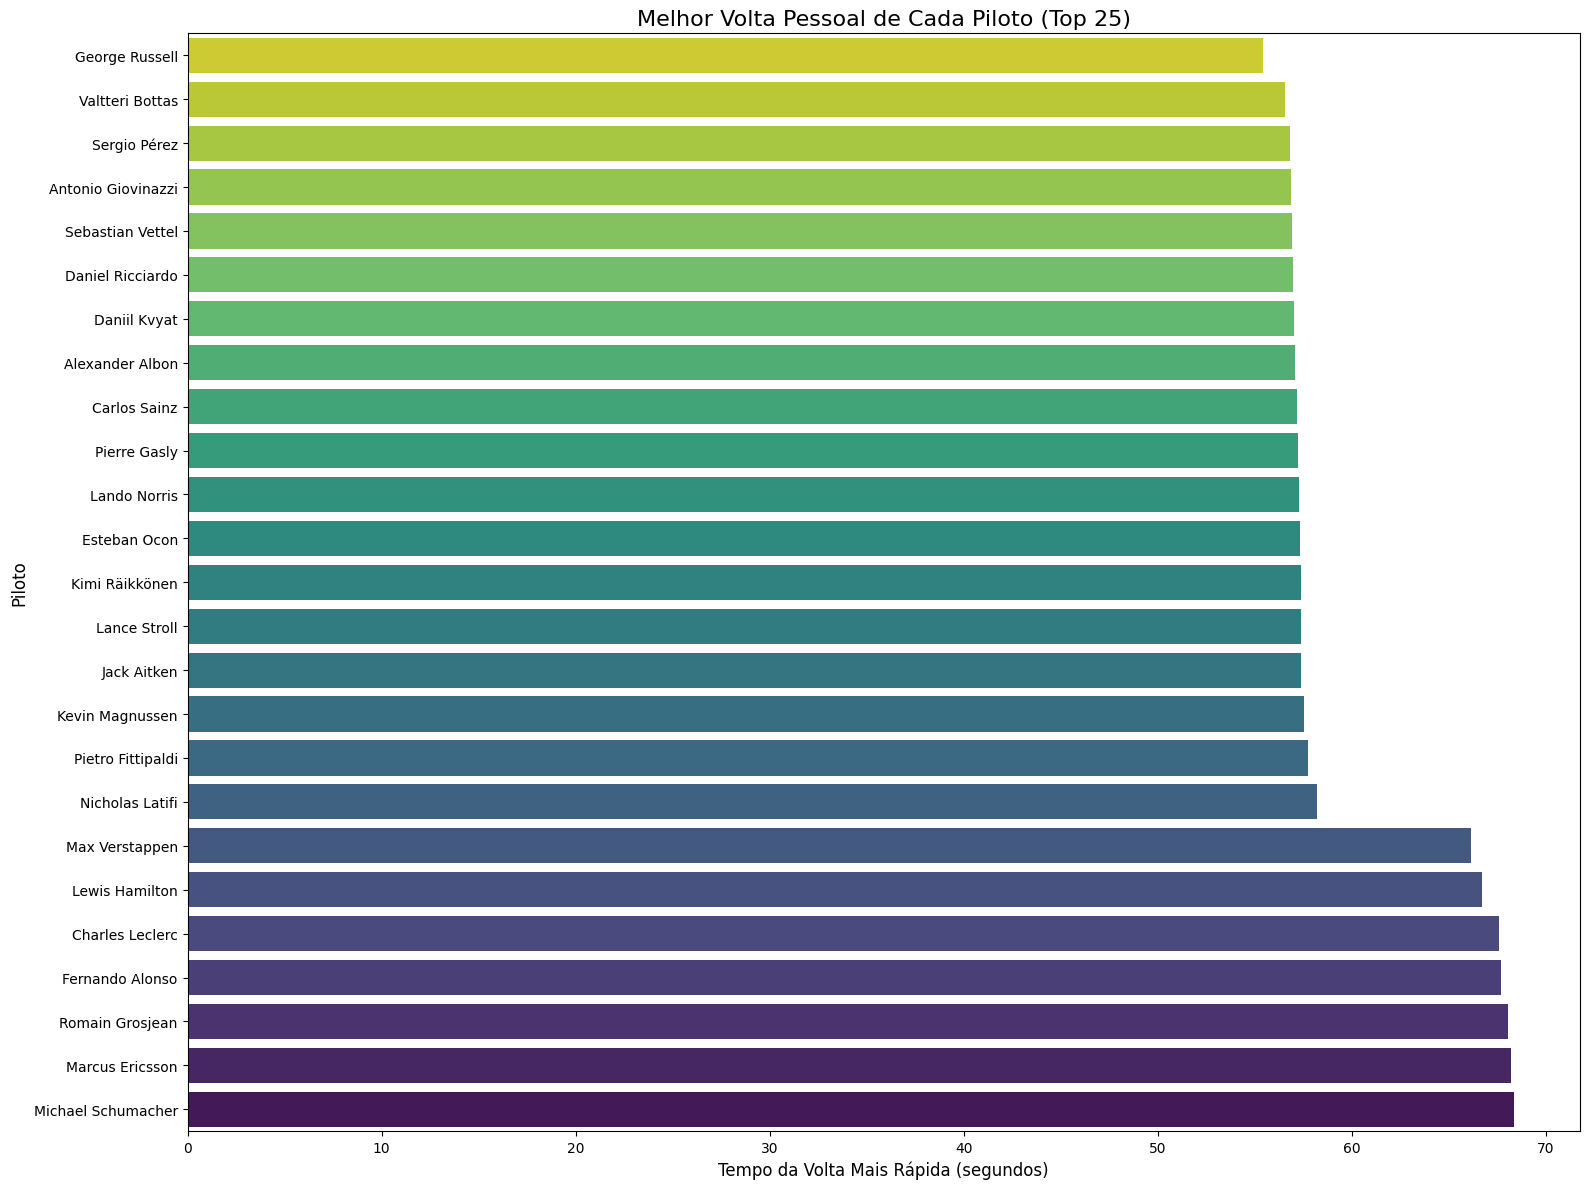

O piloto com a volta mais rápida de todos os tempos na base de dados é George Russell com o tempo de 55.404 segundos.


In [ ]:
from pyspark.sql.functions import min, col, concat_ws

# 1. Encontrar a volta mais rápida (menor tempo em ms) para cada piloto
fastest_lap_per_driver = dataframes['lap_times'].groupBy("driverId") \
    .agg(min("milliseconds").alias("fastest_lap_ms"))

# 2. Juntar com os nomes dos pilotos
drivers_with_label = dataframes['drivers'].withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))

driver_fastest_lap_details = fastest_lap_per_driver.join(drivers_with_label, "driverId") \
    .withColumn("fastest_lap_s", col("fastest_lap_ms") / 1000) \
    .orderBy("fastest_lap_s")

# 3. Converter para Pandas para plotagem
plot_data_7 = driver_fastest_lap_details.select("driver_name", "fastest_lap_s").toPandas()


# 4. Criar o gráfico de barras
# Para manter o gráfico legível, vamos mostrar os 25 pilotos com as voltas mais rápidas
plt.figure(figsize=(16, 12))
sns.barplot(
    data=plot_data_7.head(25),
    x="fastest_lap_s",
    y="driver_name",
    orient='h',
    palette="viridis_r",
    hue="driver_name",
    legend=False
)

plt.title('Melhor Volta Pessoal de Cada Piloto (Top 25)', fontsize=16)
plt.xlabel('Tempo da Volta Mais Rápida (segundos)', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()

plt.show()

# 5. Apresentar o insight
fastest_driver_overall = plot_data_7.iloc[0]

print(f"O piloto com a volta mais rápida de todos os tempos na base de dados é {fastest_driver_overall['driver_name']} com o tempo de {fastest_driver_overall['fastest_lap_s']:.3f} segundos.")

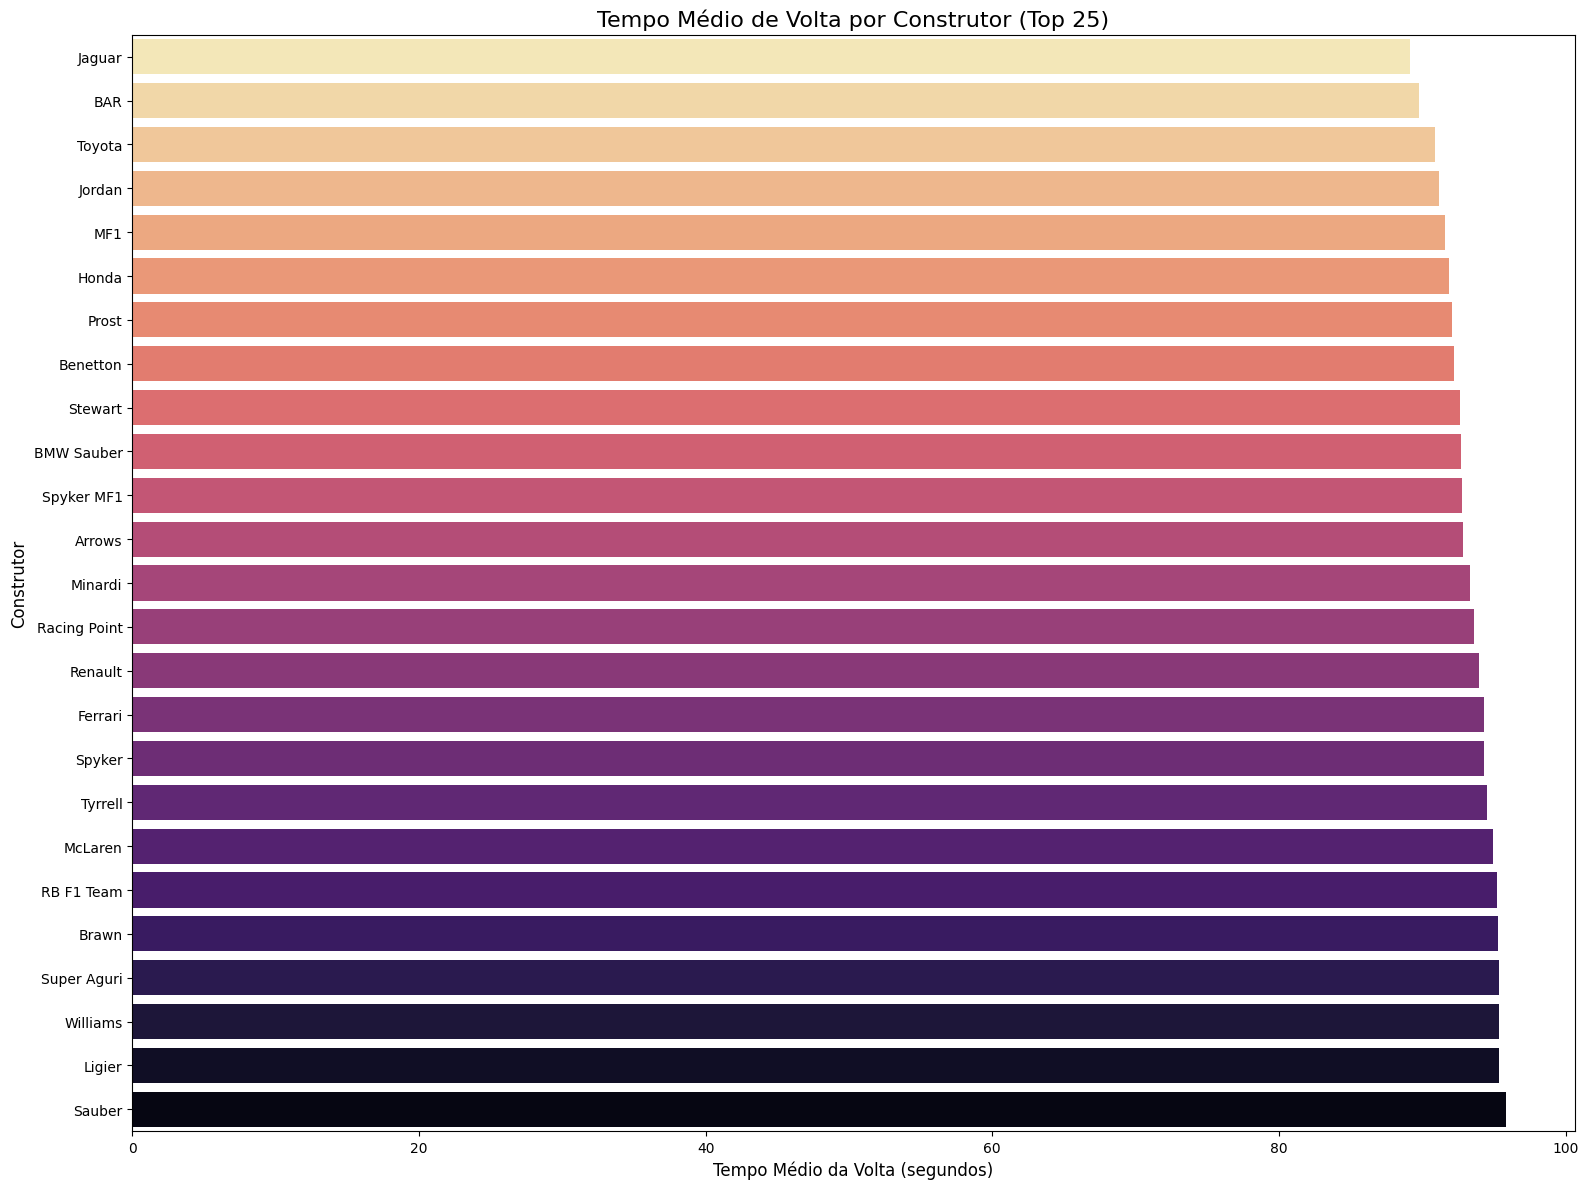

A equipe com os carros mais rápidos em média é: Jaguar com um tempo médio de volta de 89.169 segundos.


In [ ]:
from pyspark.sql.functions import avg, col

# 1. Criar um mapeamento de (raceId, driverId) -> constructorId a partir da tabela de resultados
# Usamos .distinct() para evitar dados duplicados e criar uma tabela de consulta menor
race_driver_constructor_map = dataframes['results'] \
    .select("raceId", "driverId", "constructorId") \
    .distinct()

# 2. Juntar os tempos de volta com o mapeamento para adicionar a informação do construtor
laps_with_constructors = dataframes['lap_times'].join(
    race_driver_constructor_map,
    on=["raceId", "driverId"],
    how="inner" # Usamos 'inner' para garantir que apenas voltas com dados de construtor correspondentes sejam incluídas
)

# 3. Calcular o tempo médio de volta por construtor
avg_time_per_constructor = laps_with_constructors.groupBy("constructorId") \
    .agg(avg("milliseconds").alias("avg_ms"))

# 4. Juntar com a tabela de construtores para obter os nomes
constructor_lap_details = avg_time_per_constructor.join(dataframes['constructors'], "constructorId") \
    .withColumn("avg_s", col("avg_ms") / 1000) \
    .orderBy("avg_s")

# 5. Converter para Pandas para plotagem
plot_data_8 = constructor_lap_details.select("name", "avg_s").toPandas()


# 6. Criar o gráfico de barras
plt.figure(figsize=(16, 12))
sns.barplot(
    data=plot_data_8.head(25), # Mostrando os 25 construtores mais rápidos
    x="avg_s",
    y="name",
    orient='h',
    palette="magma_r",
    hue="name",
    legend=False
)

plt.title('Tempo Médio de Volta por Construtor (Top 25)', fontsize=16)
plt.xlabel('Tempo Médio da Volta (segundos)', fontsize=12)
plt.ylabel('Construtor', fontsize=12)
plt.tight_layout()

plt.show()

# 7. Apresentar o insight
fastest_constructor = plot_data_8.iloc[0]

print(f"A equipe com os carros mais rápidos em média é: {fastest_constructor['name']} com um tempo médio de volta de {fastest_constructor['avg_s']:.3f} segundos.")

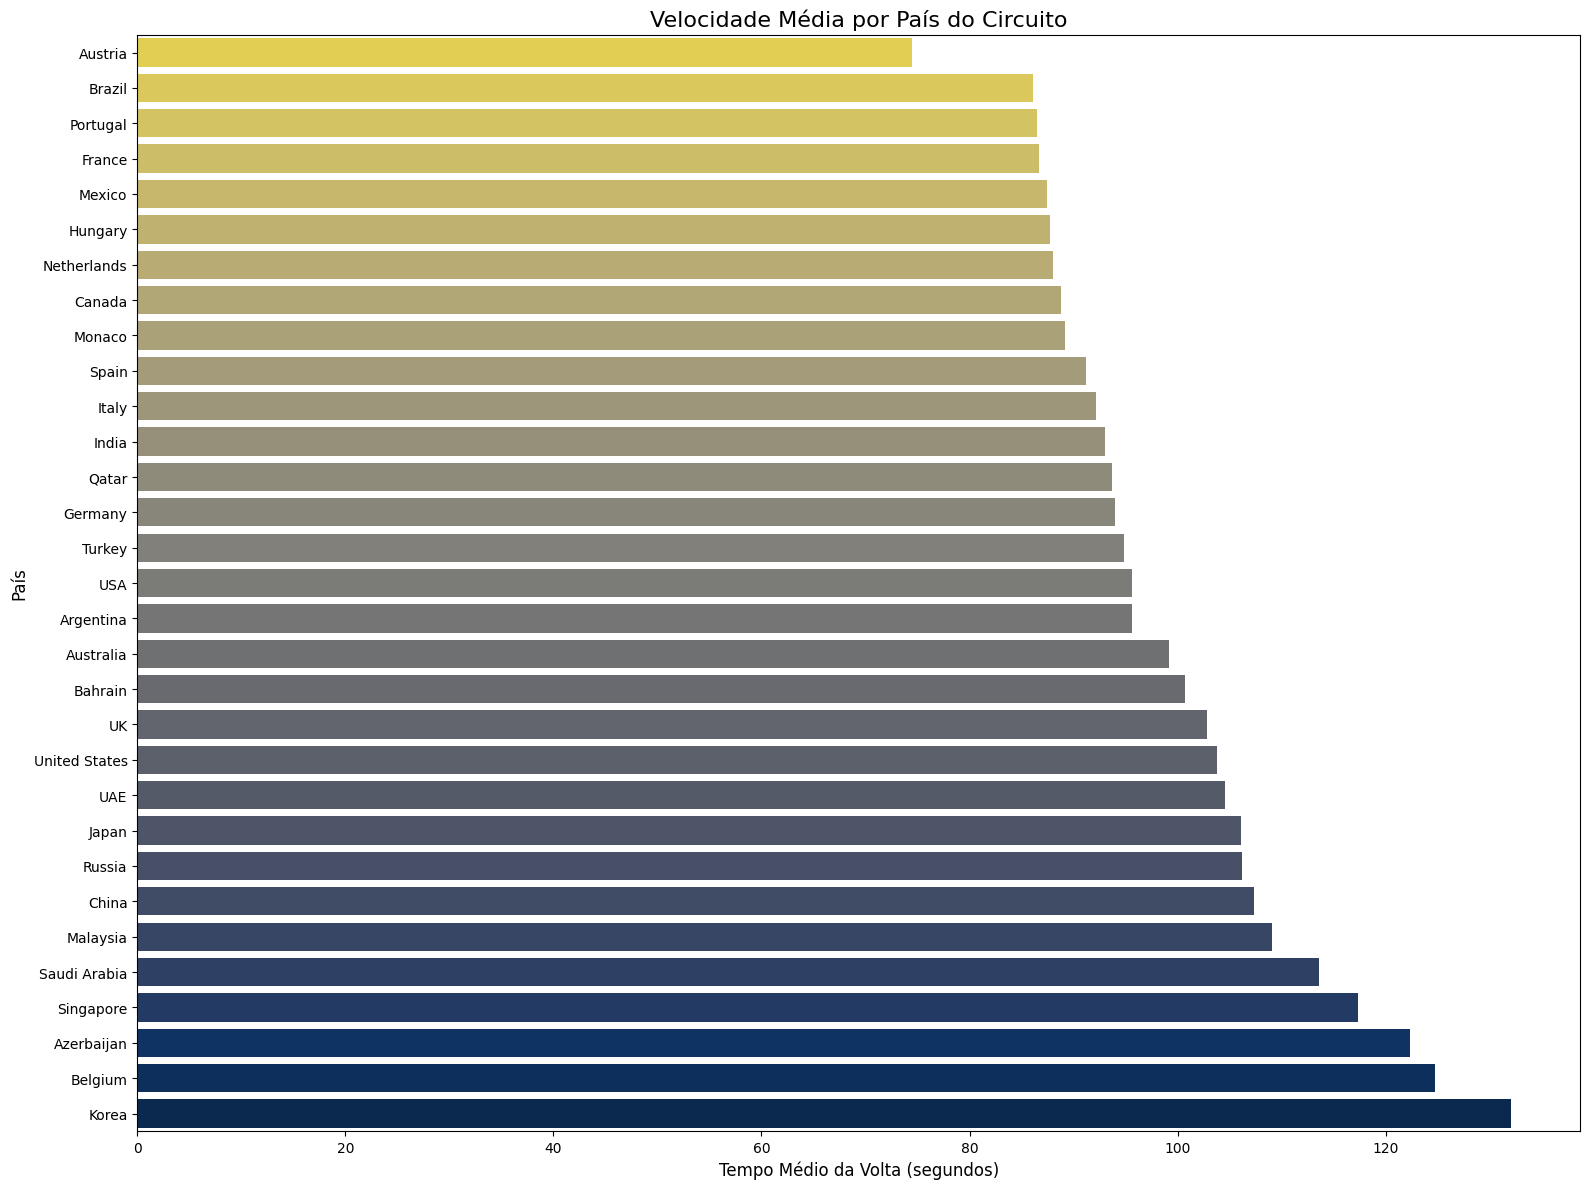

As pistas mais velozes, em média, estão na: Austria com um tempo médio de volta de 74.421 segundos.


In [ ]:
from pyspark.sql.functions import avg, col

# 1. Calcular o tempo médio de volta para cada corrida (raceId) - passo já feito antes, mas repetido para clareza
avg_time_per_race = dataframes['lap_times'].groupBy("raceId") \
    .agg(avg("milliseconds").alias("avg_lap_ms_race"))

# 2. Juntar com a tabela 'races' para obter o circuitId e depois com 'circuits' para obter o país
race_circuit_join = avg_time_per_race.join(dataframes['races'], "raceId")
race_country_join = race_circuit_join.join(dataframes['circuits'], "circuitId")

# 3. Calcular o tempo médio geral para cada país
# Agrupamos por país e tiramos a média dos tempos de todas as corridas naquele país
avg_time_per_country = race_country_join.groupBy("country") \
    .agg(avg("avg_lap_ms_race").alias("avg_country_ms")) \
    .withColumn("avg_country_s", col("avg_country_ms") / 1000) \
    .orderBy("avg_country_s")

# 4. Converter para Pandas para plotagem
plot_data_9 = avg_time_per_country.select("country", "avg_country_s").toPandas()

# 5. Criar o gráfico de barras
plt.figure(figsize=(16, 12))
sns.barplot(
    data=plot_data_9,
    x="avg_country_s",
    y="country",
    orient='h',
    palette="cividis_r",
    hue="country",
    legend=False
)

plt.title('Velocidade Média por País do Circuito', fontsize=16)
plt.xlabel('Tempo Médio da Volta (segundos)', fontsize=12)
plt.ylabel('País', fontsize=12)
plt.tight_layout()

plt.show()

# 6. Apresentar o insight
fastest_country = plot_data_9.iloc[0]

print(f"As pistas mais velozes, em média, estão na: {fastest_country['country']} com um tempo médio de volta de {fastest_country['avg_country_s']:.3f} segundos.")

C:\Users\julii\AppData\Local\Temp\ipykernel_7464\3748245726.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


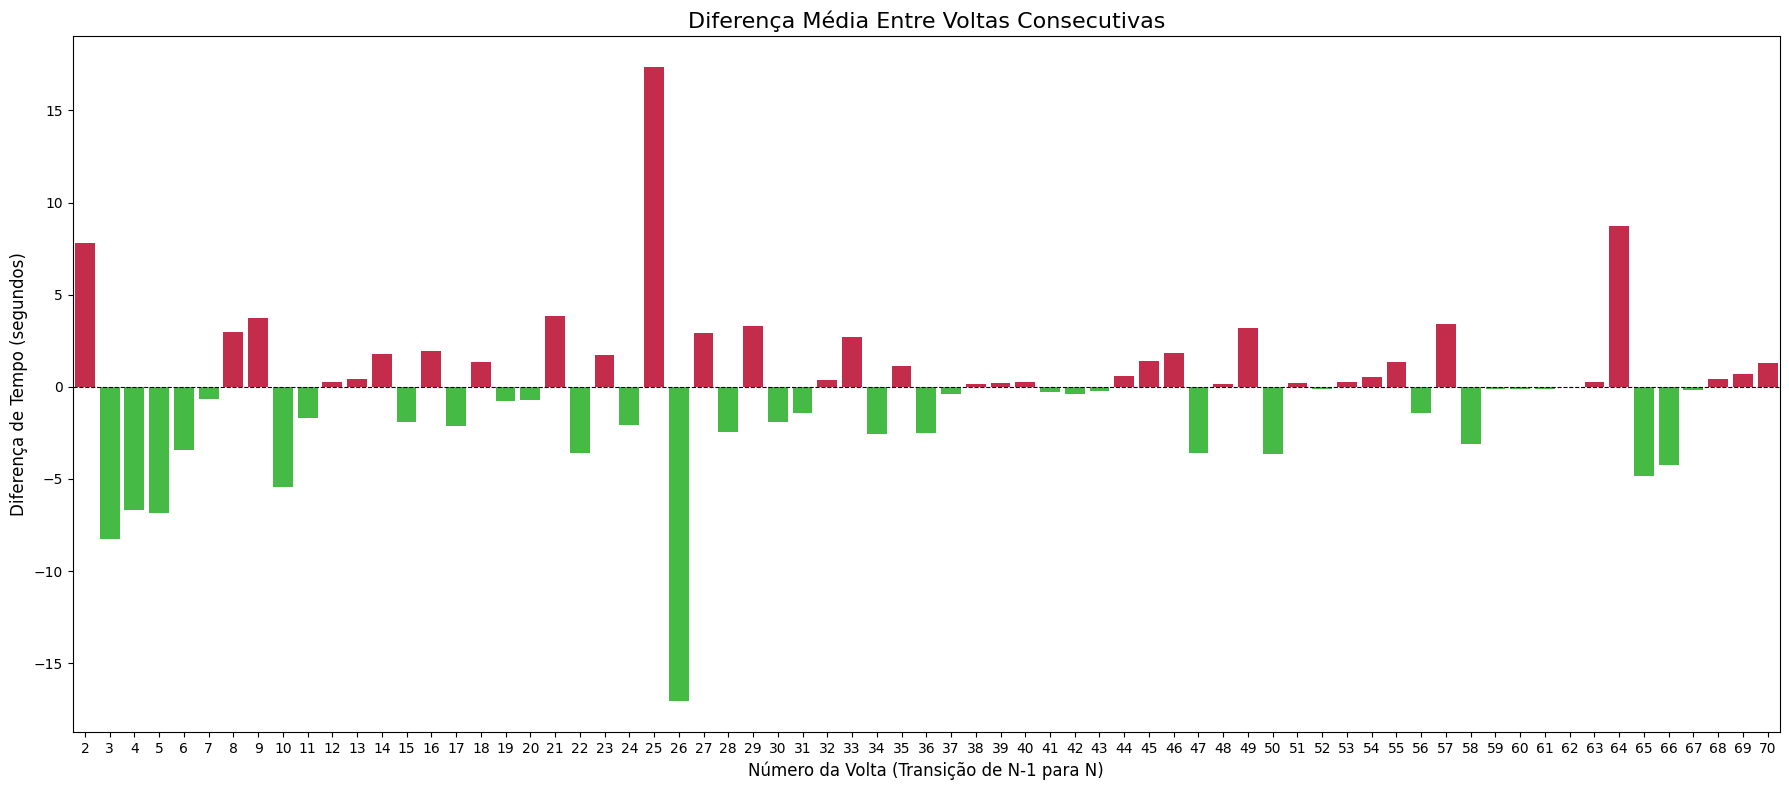

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, col, avg

# 1. Definir a janela de operação
# A janela particiona os dados por corrida e piloto, e ordena pelas voltas
window_spec = Window.partitionBy("raceId", "driverId").orderBy("lap")

# 2. Usar a função lag() para obter o tempo da volta anterior
laps_with_previous = dataframes['lap_times'].withColumn(
    "prev_lap_ms",
    lag("milliseconds", 1).over(window_spec)
)

# 3. Calcular a diferença e filtrar as primeiras voltas (que não têm volta anterior)
lap_delta_df = laps_with_previous \
    .withColumn("delta_ms", col("milliseconds") - col("prev_lap_ms")) \
    .filter(col("delta_ms").isNotNull())

# 4. Agrupar pela volta para encontrar a média da diferença
avg_delta_per_lap = lap_delta_df.groupBy("lap") \
    .agg(avg("delta_ms").alias("avg_delta_ms")) \
    .withColumn("avg_delta_s", col("avg_delta_ms") / 1000) \
    .orderBy("lap")

# 5. Converter para Pandas para plotagem, limitando a 70 voltas
plot_data_10 = avg_delta_per_lap.filter(col("lap") <= 70).toPandas()


# 6. Criar o gráfico de barras
plt.figure(figsize=(18, 8))
# Criar uma paleta de cores para valores positivos (perda de tempo) e negativos (ganho de tempo)
palette = ['crimson' if x > 0 else 'limegreen' for x in plot_data_10['avg_delta_s']]
sns.barplot(
    data=plot_data_10,
    x="lap",
    y="avg_delta_s",
    palette=palette
)

# Adicionar uma linha de referência em y=0
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

plt.title('Diferença Média Entre Voltas Consecutivas', fontsize=16)
plt.xlabel('Número da Volta (Transição de N-1 para N)', fontsize=12)
plt.ylabel('Diferença de Tempo (segundos)', fontsize=12)
plt.tight_layout()

plt.show()

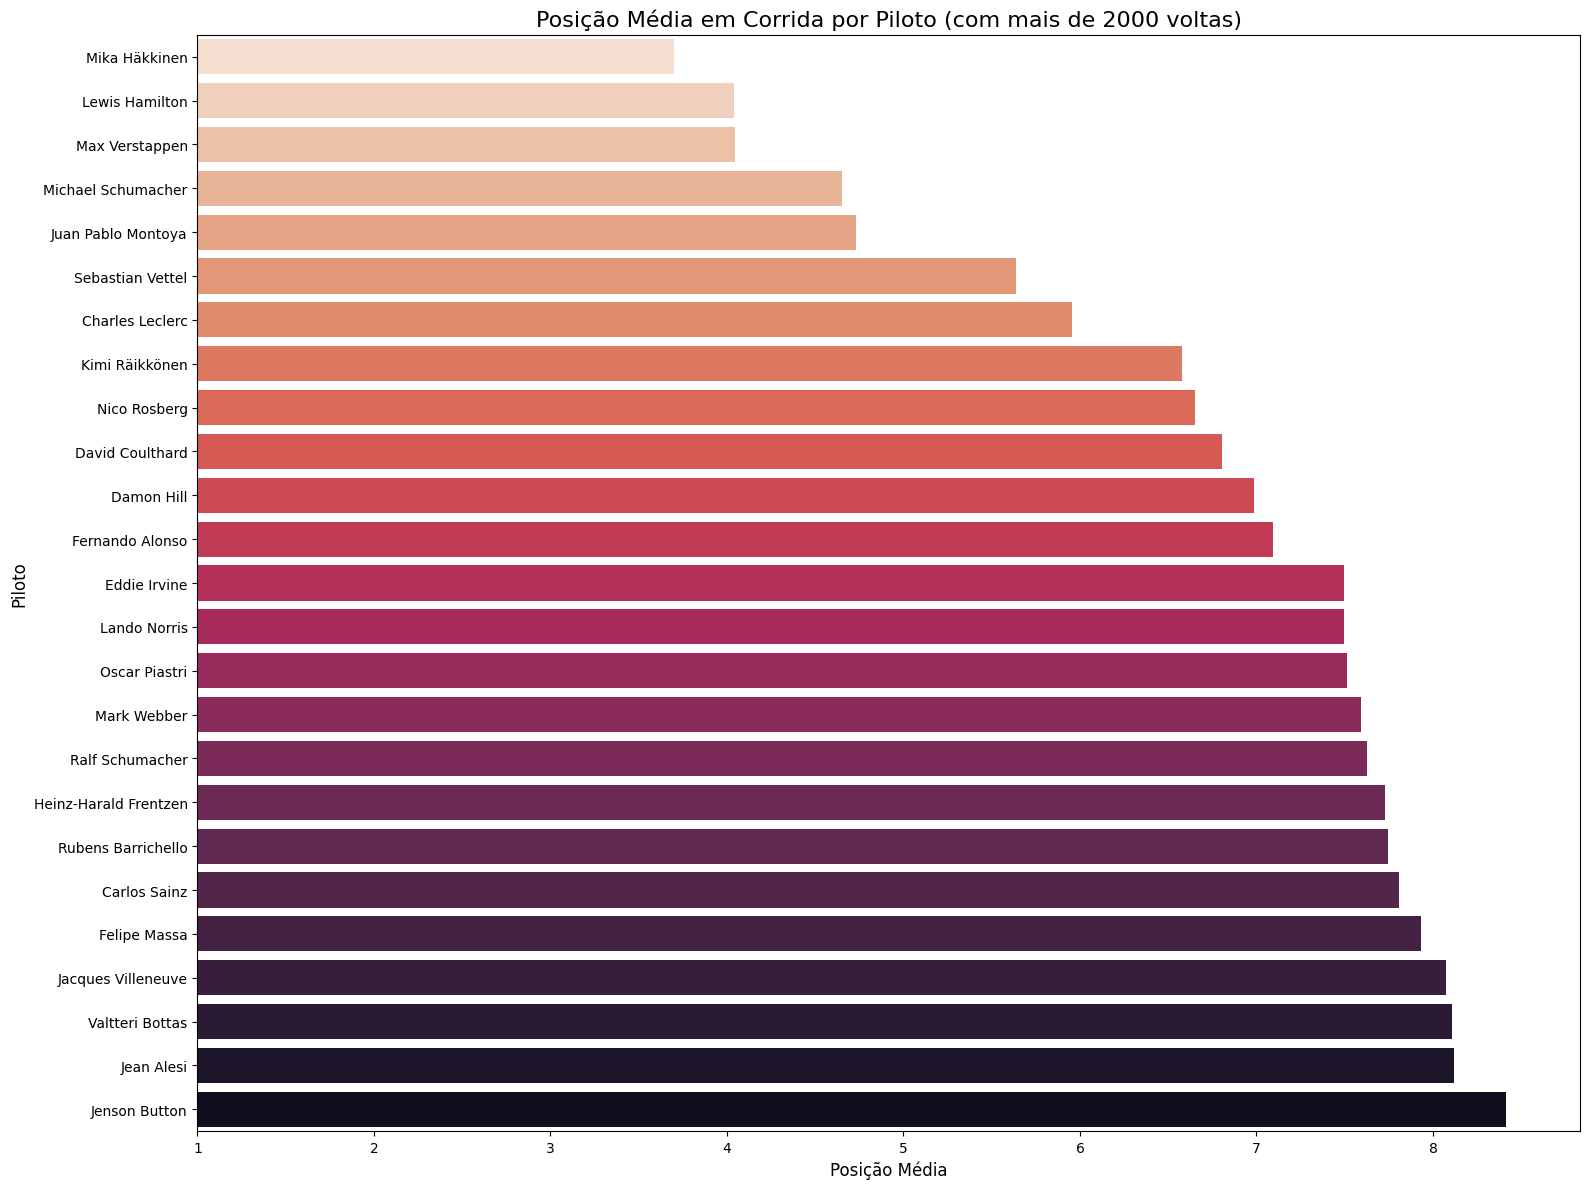

O piloto com a melhor posição média em corrida, indicando maior estabilidade na liderança, é: Mika Häkkinen com uma posição média de 3.70.


In [ ]:
from pyspark.sql.functions import avg, col, count, concat_ws

# 1. Encontrar pilotos com um número significativo de voltas (mais de 2000)
# Isso torna a comparação da posição média mais justa
experienced_drivers = dataframes['lap_times'].groupBy("driverId") \
    .agg(count("*").alias("total_laps")) \
    .filter(col("total_laps") > 2000) \
    .select("driverId")

# 2. Calcular a posição média, mas apenas para os pilotos experientes
avg_position_per_driver = dataframes['lap_times'] \
    .join(experienced_drivers, "driverId", "inner") \
    .groupBy("driverId") \
    .agg(avg("position").alias("avg_position"))

# 3. Juntar com os nomes dos pilotos e ordenar
drivers_with_label = dataframes['drivers'].withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))

driver_avg_position_details = avg_position_per_driver.join(drivers_with_label, "driverId") \
    .orderBy("avg_position")

# 4. Converter para Pandas para plotagem
plot_data_11 = driver_avg_position_details.select("driver_name", "avg_position").toPandas()

# 5. Criar o gráfico de barras
plt.figure(figsize=(16, 12))
sns.barplot(
    data=plot_data_11.head(25), # Mostrando os 25 pilotos com a melhor posição média
    x="avg_position",
    y="driver_name",
    orient='h',
    palette="rocket_r",
    hue="driver_name",
    legend=False
)

# Definir o limite do eixo x para começar em 1, que é a melhor posição possível
plt.xlim(left=1)

plt.title('Posição Média em Corrida por Piloto (com mais de 2000 voltas)', fontsize=16)
plt.xlabel('Posição Média', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()

plt.show()

# 6. Apresentar o insight
most_stable_driver = plot_data_11.iloc[0]

print(f"O piloto com a melhor posição média em corrida, indicando maior estabilidade na liderança, é: {most_stable_driver['driver_name']} com uma posição média de {most_stable_driver['avg_position']:.2f}.")

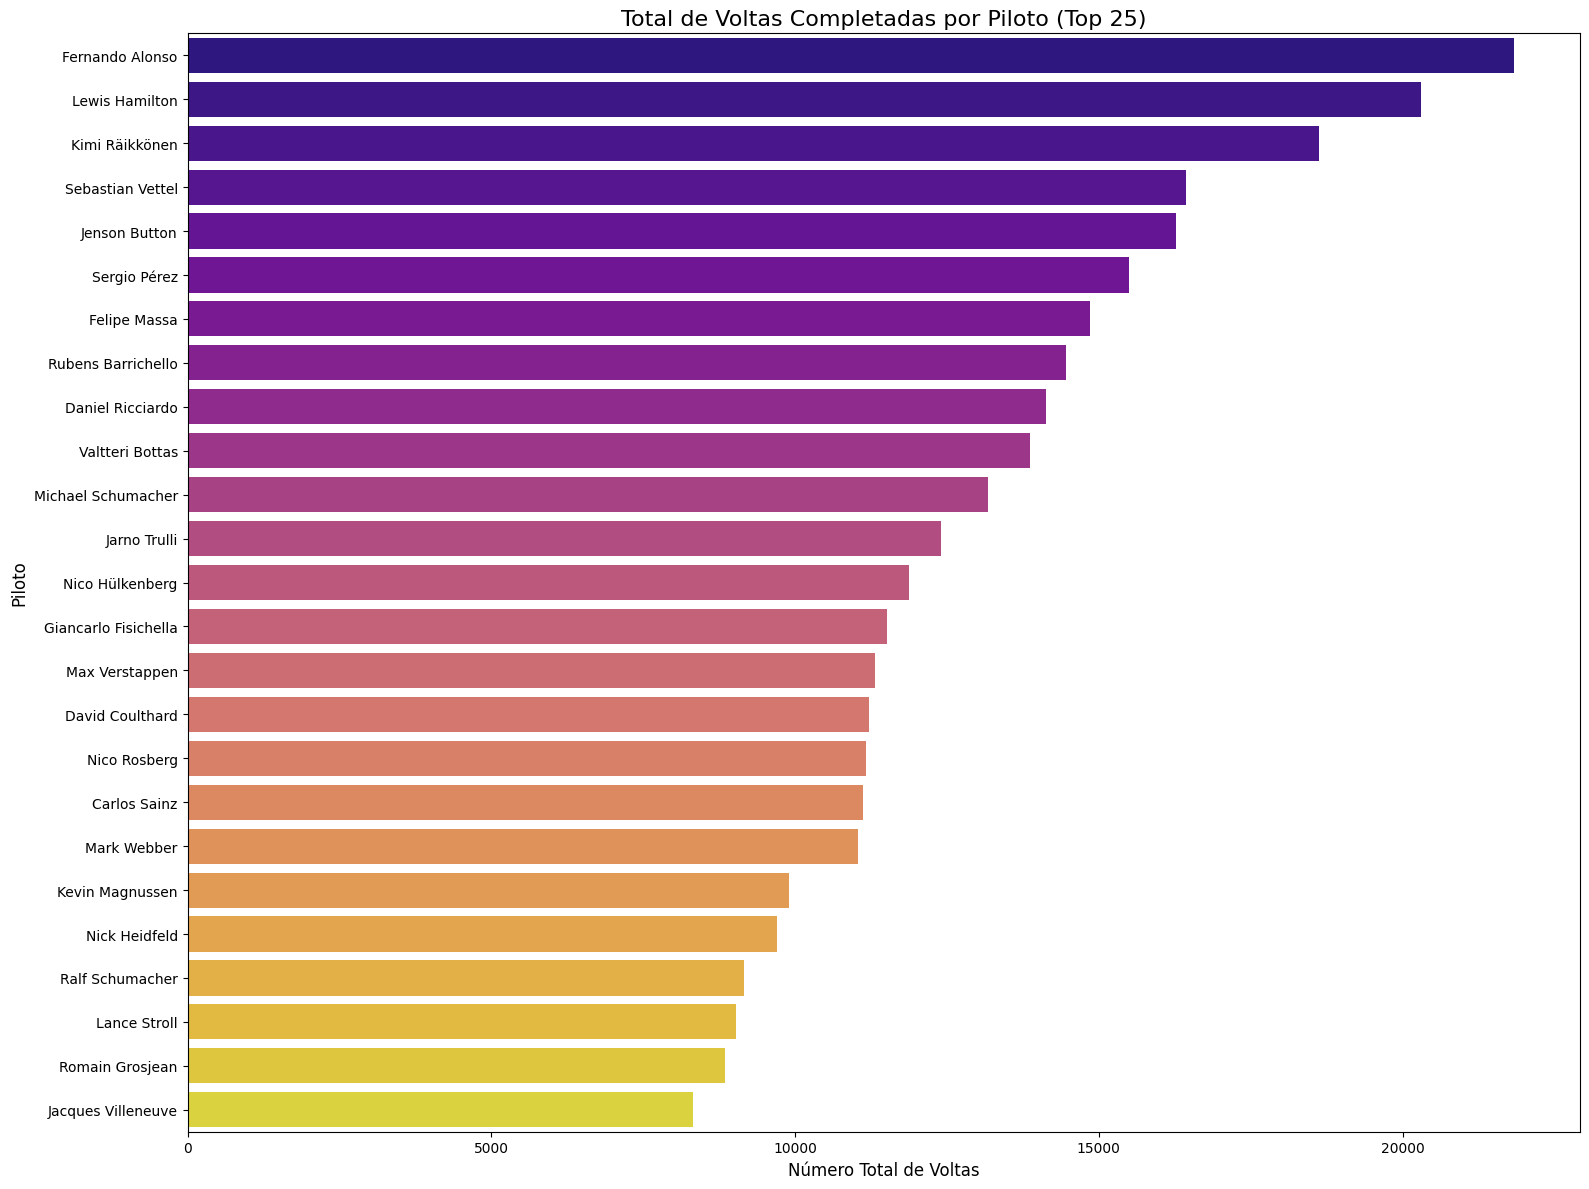

O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: Fernando Alonso com um total de 21829 voltas.


In [ ]:
from pyspark.sql.functions import count, col, concat_ws

# 1. Contar o número de voltas para cada piloto
total_laps_per_driver = dataframes['lap_times'].groupBy("driverId") \
    .agg(count("*").alias("total_laps"))

# 2. Juntar com os nomes dos pilotos e ordenar
drivers_with_label = dataframes['drivers'].withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))

driver_laps_details = total_laps_per_driver.join(drivers_with_label, "driverId") \
    .orderBy(col("total_laps").desc()) # Ordenar em ordem decrescente

# 3. Converter para Pandas para plotagem
plot_data_12 = driver_laps_details.select("driver_name", "total_laps").toPandas()

# 4. Criar o gráfico de barras
plt.figure(figsize=(16, 12))
sns.barplot(
    data=plot_data_12.head(25), # Mostrando os 25 pilotos com mais voltas
    x="total_laps",
    y="driver_name",
    orient='h',
    palette="plasma",
    hue="driver_name",
    legend=False
)

plt.title('Total de Voltas Completadas por Piloto (Top 25)', fontsize=16)
plt.xlabel('Número Total de Voltas', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()

plt.show()

# 5. Apresentar o insight
most_laps_driver = plot_data_12.iloc[0]

print(f"O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: {most_laps_driver['driver_name']} com um total de {most_laps_driver['total_laps']} voltas.")

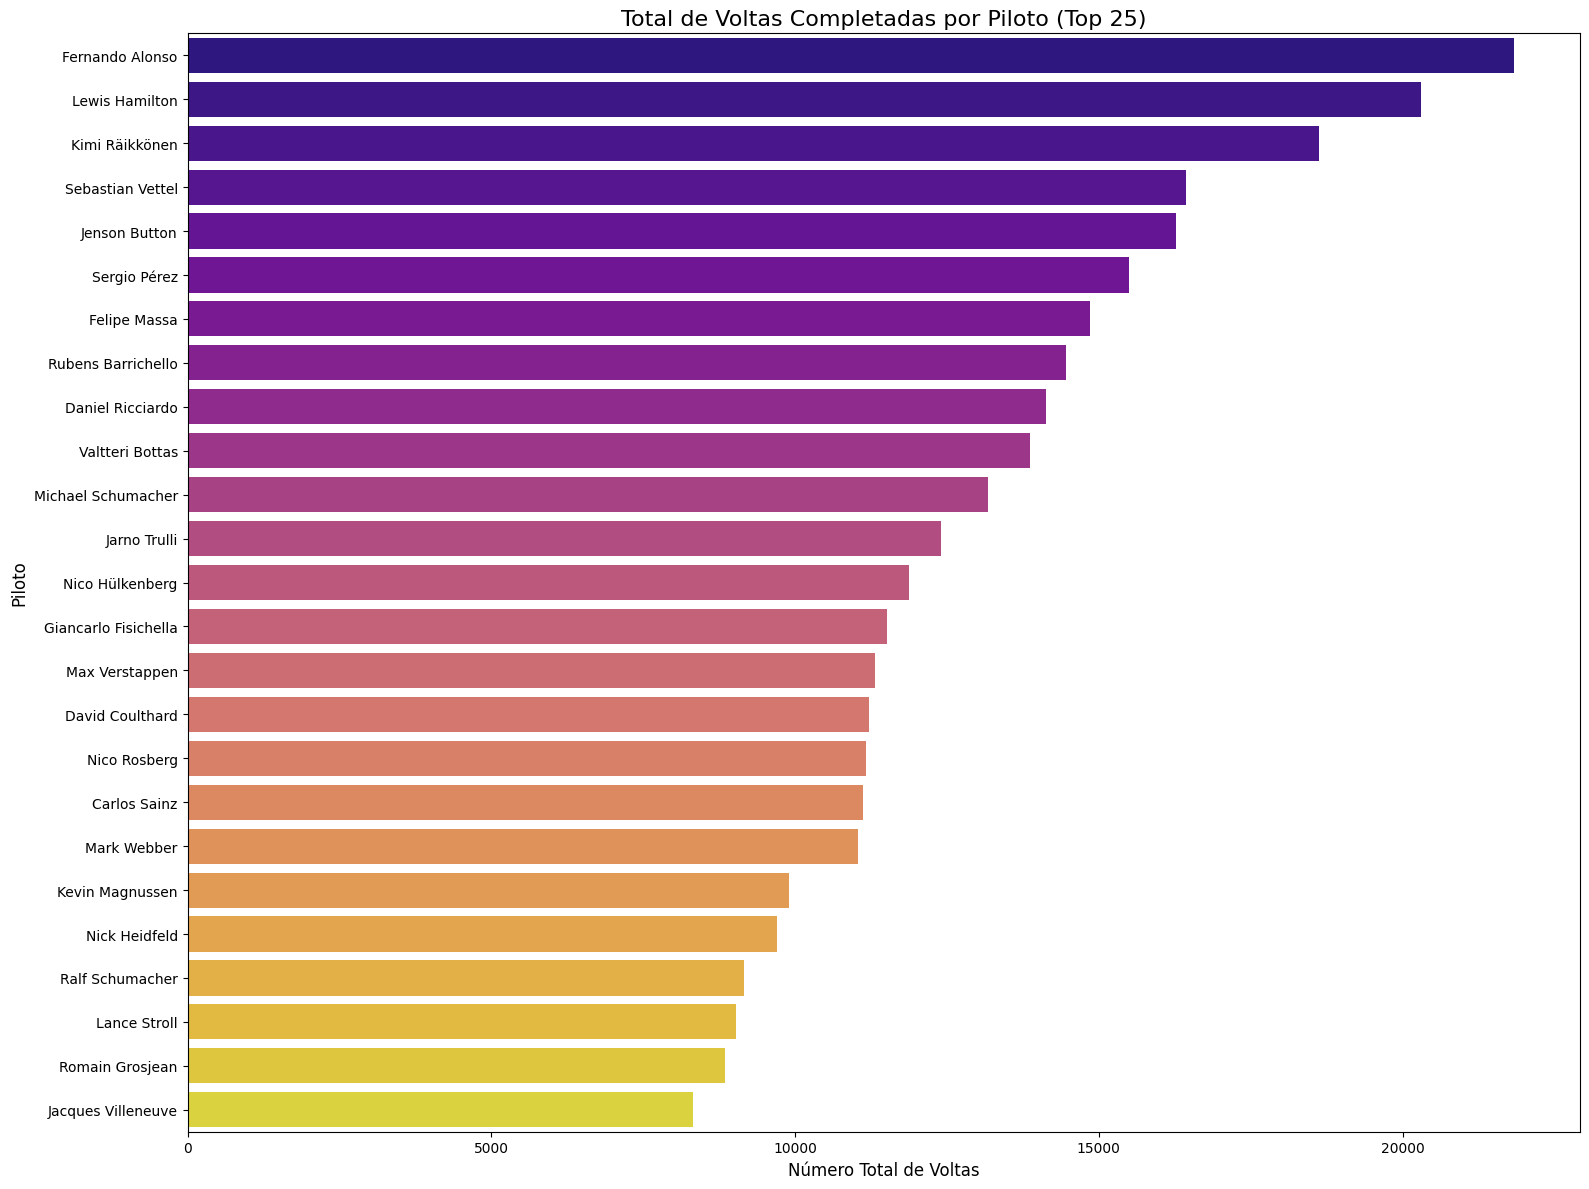

O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: Fernando Alonso com um total de 21829 voltas.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import count, col, concat_ws

# Assumindo que 'dataframes' é o seu dicionário com os DataFrames do Spark
# e 'spark' é a sua SparkSession ativa.

# 1. Contar o número de voltas para cada piloto
total_laps_per_driver = dataframes['lap_times'].groupBy("driverId") \
    .agg(count("*").alias("total_laps"))

# 2. Juntar com os nomes dos pilotos e ordenar
drivers_with_label = dataframes['drivers'].withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))

driver_laps_details = total_laps_per_driver.join(drivers_with_label, "driverId") \
    .orderBy(col("total_laps").desc()) # Ordenar em ordem decrescente

# 3. Converter para Pandas para plotagem
plot_data_12 = driver_laps_details.select("driver_name", "total_laps").toPandas()

# 4. Criar o gráfico de barras
plt.figure(figsize=(16, 12))
sns.barplot(
    data=plot_data_12.head(25), # Mostrando os 25 pilotos com mais voltas
    x="total_laps",
    y="driver_name",
    orient='h',
    palette="plasma",
    hue="driver_name",
    legend=False
)

plt.title('Total de Voltas Completadas por Piloto (Top 25)', fontsize=16)
plt.xlabel('Número Total de Voltas', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()

# Salvar o arquivo e exibir o gráfico
plt.show()

# 5. Apresentar o insight
most_laps_driver = plot_data_12.iloc[0]

print(f"O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: {most_laps_driver['driver_name']} com um total de {most_laps_driver['total_laps']} voltas.")

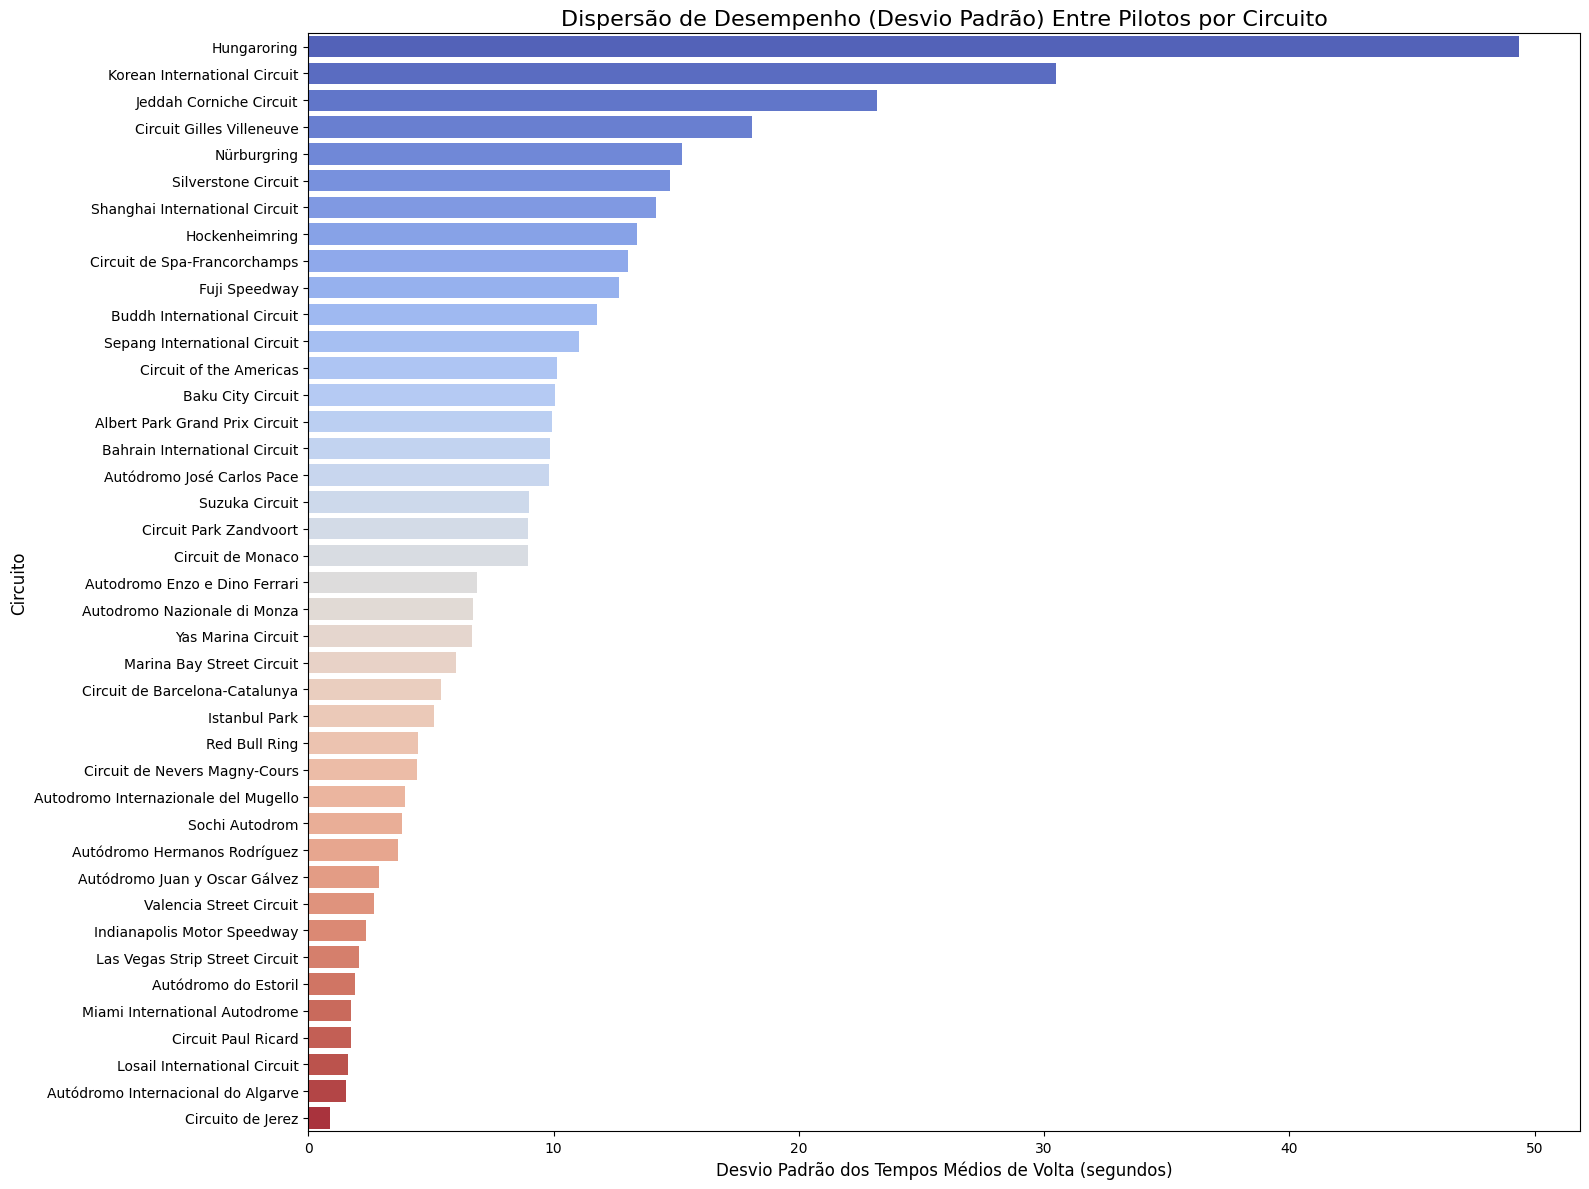

O circuito com a maior dispersão de tempos (sugestão de domínio) é: 'Hungaroring' com um desvio padrão de 49.385 segundos.
O circuito com a menor dispersão de tempos (sugestão de disputa acirrada) é: 'Circuito de Jerez' com um desvio padrão de 0.871 segundos.


In [ ]:
from pyspark.sql.functions import avg, stddev, col

# Etapa 1: Juntar as tabelas para ter voltas, pilotos e circuitos na mesma base
laps_with_races = dataframes['lap_times'].join(dataframes['races'], "raceId")

# Etapa 2: Calcular o tempo médio de volta para CADA PILOTO em CADA CIRCUITO
avg_time_per_driver_circuit = laps_with_races.groupBy("circuitId", "driverId") \
    .agg(avg("milliseconds").alias("avg_driver_circuit_ms"))

# Etapa 3: Calcular o desvio padrão desses tempos médios para CADA CIRCUITO
# Isso mede a dispersão (spread) de performance entre os pilotos no mesmo circuito
performance_spread_per_circuit = avg_time_per_driver_circuit.groupBy("circuitId") \
    .agg(stddev("avg_driver_circuit_ms").alias("spread_ms"))

# Etapa 4: Juntar com os nomes dos circuitos para a visualização
spread_details = performance_spread_per_circuit.join(dataframes['circuits'], "circuitId") \
    .withColumn("spread_s", col("spread_ms") / 1000) \
    .orderBy(col("spread_s").desc()) # Ordenar pelo maior spread

# Etapa 5: Converter para Pandas para plotagem
plot_data_14 = spread_details.select("name", "spread_s").toPandas()

# Etapa 6: Criar o gráfico de barras
plt.figure(figsize=(16, 12))
sns.barplot(
    data=plot_data_14,
    x="spread_s",
    y="name",
    orient='h',
    palette="coolwarm",
    hue="name",
    legend=False
)

plt.title('Dispersão de Desempenho (Desvio Padrão) Entre Pilotos por Circuito', fontsize=16)
plt.xlabel('Desvio Padrão dos Tempos Médios de Volta (segundos)', fontsize=12)
plt.ylabel('Circuito', fontsize=12)
plt.tight_layout()

plt.show()

# Etapa 7: Apresentar o insight
most_disputed_circuit = plot_data_14.iloc[-1] # Último da lista (menor spread)
most_dominated_circuit = plot_data_14.iloc[0] # Primeiro da lista (maior spread)

print(f"O circuito com a maior dispersão de tempos (sugestão de domínio) é: '{most_dominated_circuit['name']}' com um desvio padrão de {most_dominated_circuit['spread_s']:.3f} segundos.")
print(f"O circuito com a menor dispersão de tempos (sugestão de disputa acirrada) é: '{most_disputed_circuit['name']}' com um desvio padrão de {most_disputed_circuit['spread_s']:.3f} segundos.")

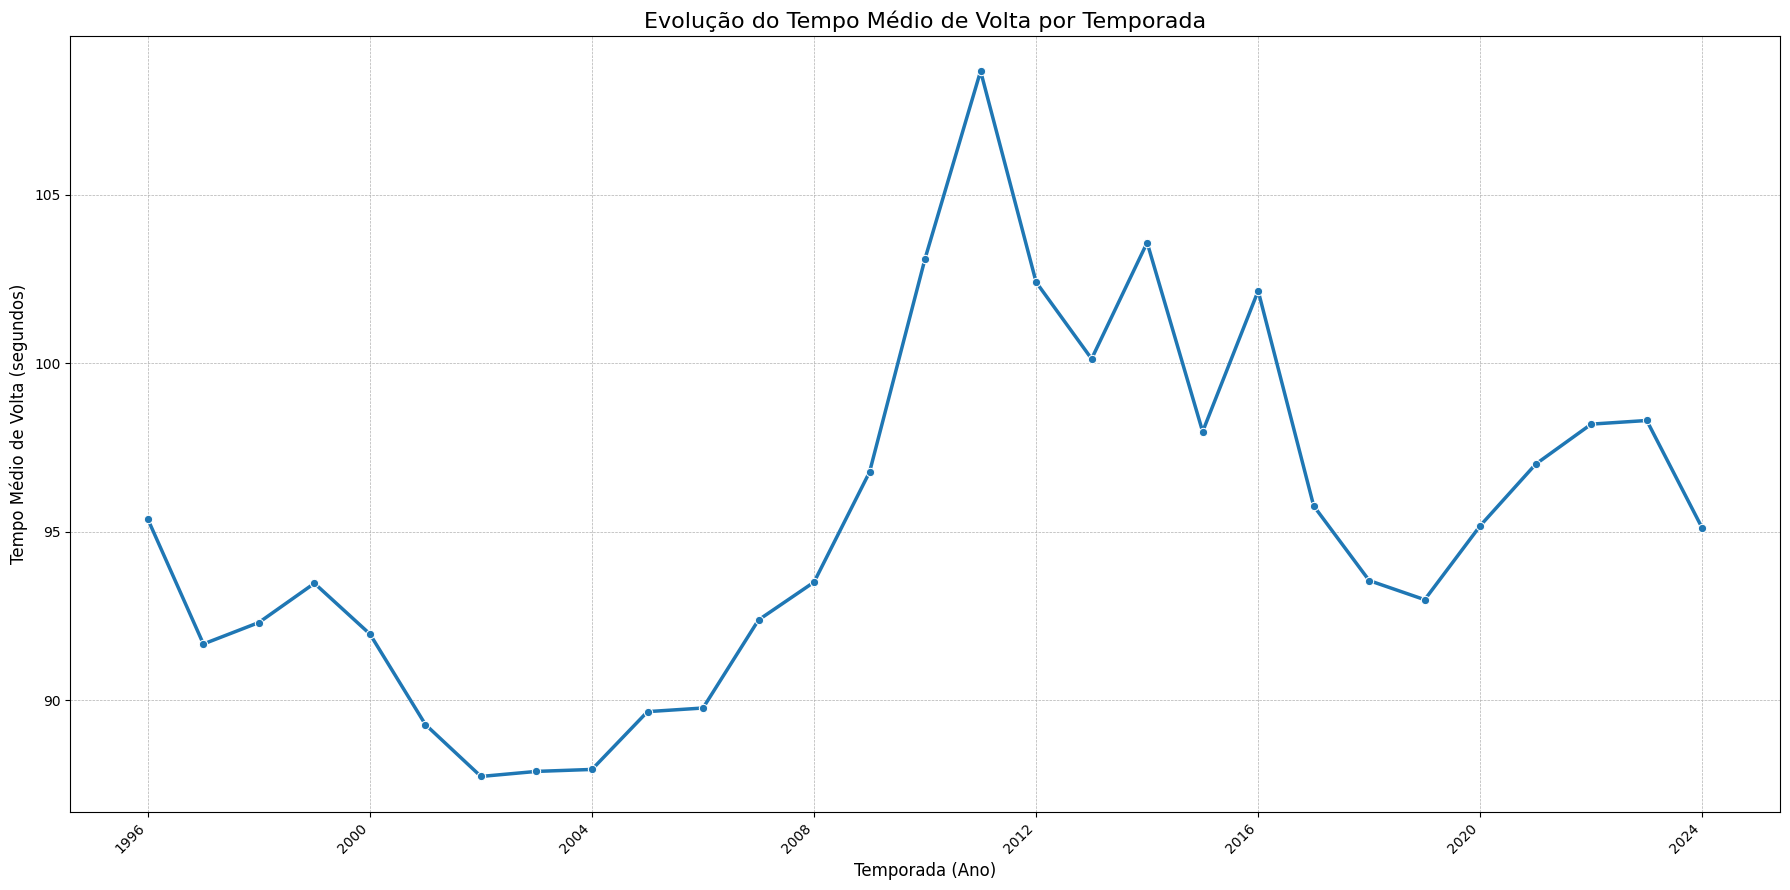

In [ ]:
from pyspark.sql.functions import avg, col
from matplotlib.ticker import MaxNLocator

# 1. Juntar lap_times com races para obter o ano de cada volta
laps_with_year = dataframes['lap_times'].join(dataframes['races'], "raceId")

# 2. Agrupar por ano e calcular o tempo médio de volta
avg_time_per_season = laps_with_year.groupBy("year") \
    .agg(avg("milliseconds").alias("avg_ms")) \
    .withColumn("avg_s", col("avg_ms") / 1000) \
    .orderBy("year")

# 3. Converter para Pandas para plotagem
plot_data_15 = avg_time_per_season.toPandas()

# 4. Criar o gráfico de linha
plt.figure(figsize=(18, 9))
ax = sns.lineplot(
    data=plot_data_15,
    x="year",
    y="avg_s",
    marker='o',
    linewidth=2.5
)

# Garantir que os ticks do eixo X sejam números inteiros para os anos
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45, ha="right")

plt.title('Evolução do Tempo Médio de Volta por Temporada', fontsize=16)
plt.xlabel('Temporada (Ano)', fontsize=12)
plt.ylabel('Tempo Médio de Volta (segundos)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

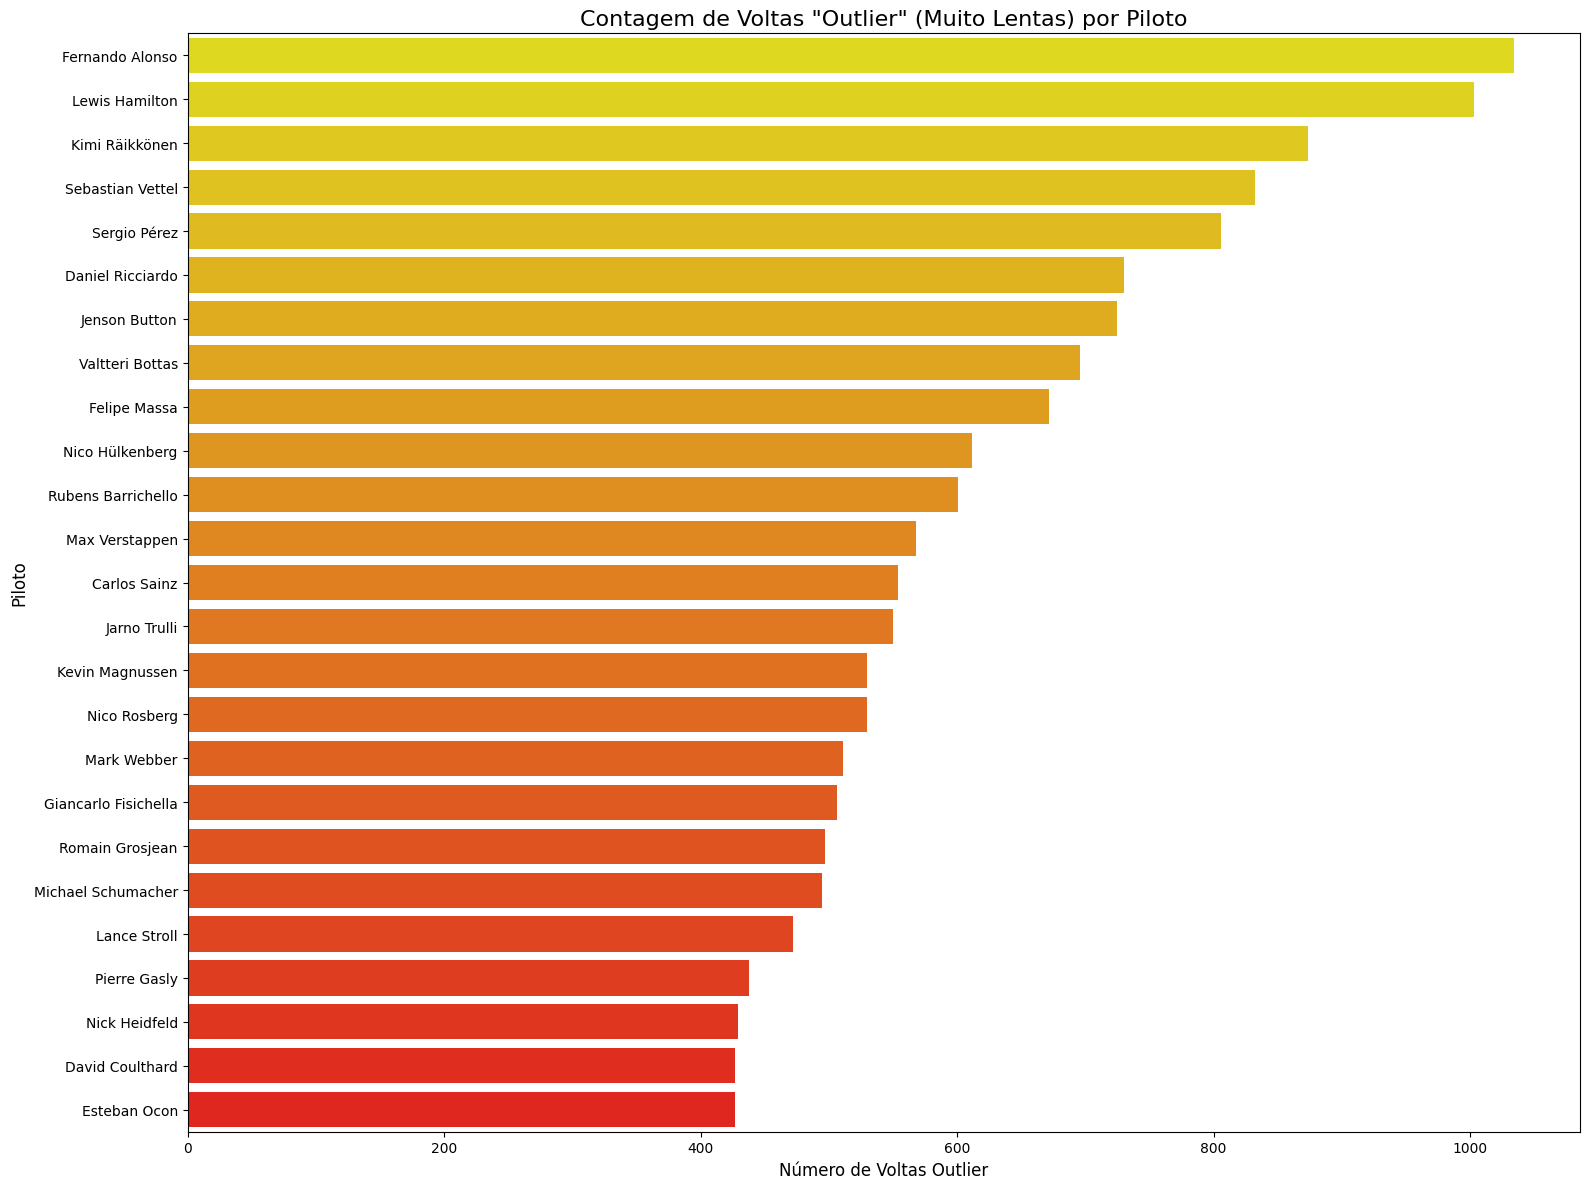


--- Top 20 Voltas Mais Lentas (em relação à média da corrida) ---


,race_event,driver_name,lap,lap_time_s,race_avg_s,slower_by_s
0,Canadian Grand Prix 2011,Nick Heidfeld,25,"7,507.55s",220.45s,"+7,287.10s"
1,Canadian Grand Prix 2011,Felipe Massa,25,"7,506.66s",220.45s,"+7,286.21s"
2,Canadian Grand Prix 2011,Vitaly Petrov,25,"7,506.24s",220.45s,"+7,285.79s"
3,Canadian Grand Prix 2011,Kamui Kobayashi,25,"7,506.10s",220.45s,"+7,285.64s"
4,Canadian Grand Prix 2011,Sebastian Vettel,25,"7,505.15s",220.45s,"+7,284.70s"
5,Canadian Grand Prix 2011,Mark Webber,25,"7,505.03s",220.45s,"+7,284.58s"
6,Canadian Grand Prix 2011,Fernando Alonso,25,"7,504.23s",220.45s,"+7,283.78s"
7,Canadian Grand Prix 2011,Paul di Resta,25,"7,503.98s",220.45s,"+7,283.53s"
8,Canadian Grand Prix 2011,Pedro de la Rosa,25,"7,503.80s",220.45s,"+7,283.34s"
9,Canadian Grand Prix 2011,Jenson Button,25,"7,503.77s",220.45s,"+7,283.32s"


In [ ]:
from pyspark.sql.functions import avg, stddev, col, count, concat_ws

# 1. Calcular a média e o desvio padrão para cada corrida
race_stats = dataframes['lap_times'].groupBy("raceId") \
    .agg(
        avg("milliseconds").alias("avg_ms_race"),
        stddev("milliseconds").alias("stddev_ms_race")
    )

# 2. Juntar as estatísticas com os dados de todas as voltas
laps_with_stats = dataframes['lap_times'].join(race_stats, "raceId")

# 3. Definir o limite do outlier e filtrar as voltas que o excedem
outlier_threshold = col("avg_ms_race") + (2 * col("stddev_ms_race"))
outlier_laps = laps_with_stats.filter(col("milliseconds") > outlier_threshold)

# 4. Enriquecer os dados com nomes de pilotos e corridas para a tabela
drivers_with_label = dataframes['drivers'].withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))
races_with_label = dataframes['races'].withColumn("race_event", concat_ws(" ", col("name"), col("year")))

outliers_with_details = outlier_laps.join(drivers_with_label, "driverId") \
    .join(races_with_label, "raceId") \
    .withColumn("lap_time_s", col("milliseconds") / 1000) \
    .withColumn("race_avg_s", col("avg_ms_race") / 1000) \
    .withColumn("slower_by_s", (col("milliseconds") - col("avg_ms_race")) / 1000) \
    .orderBy(col("slower_by_s").desc())

# --- Visualização 1: Contagem de Outliers por Piloto ---

outlier_counts_per_driver = outliers_with_details.groupBy("driver_name") \
    .agg(count("*").alias("outlier_count")) \
    .orderBy(col("outlier_count").desc())

plot_data_16 = outlier_counts_per_driver.toPandas()

plt.figure(figsize=(16, 12))
sns.barplot(
    data=plot_data_16.head(25),
    x="outlier_count",
    y="driver_name",
    orient='h',
    palette="autumn_r",
    hue="driver_name",
    legend=False
)
plt.title('Contagem de Voltas "Outlier" (Muito Lentas) por Piloto', fontsize=16)
plt.xlabel('Número de Voltas Outlier', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()
plt.show()


# --- Visualização 2: Tabela com os Top 20 Piores Outliers ---

top_20_outliers_pd = outliers_with_details \
    .select("race_event", "driver_name", "lap", "lap_time_s", "race_avg_s", "slower_by_s") \
    .limit(20).toPandas()

print("\n--- Top 20 Voltas Mais Lentas (em relação à média da corrida) ---")
# Formatando as colunas de tempo para melhor legibilidade
top_20_outliers_pd['lap_time_s'] = top_20_outliers_pd['lap_time_s'].map('{:,.2f}s'.format)
top_20_outliers_pd['race_avg_s'] = top_20_outliers_pd['race_avg_s'].map('{:,.2f}s'.format)
top_20_outliers_pd['slower_by_s'] = top_20_outliers_pd['slower_by_s'].map('+{:,.2f}s'.format)
display(top_20_outliers_pd)